# **Cause of Pharmacy Deserts in Allegheny County**
#### Group members: Alison Ngau, Morgan Powers, Maggie Piro, Tijn van Nieuwenhuyzen

## Abstract
The goal of this project is to predict the cause of pharmacy deserts in Allegheny County, Pennsylvania. A pharmacy desert is an urban area with difficult access to local pharmacies. Pharmacies such as Rite Aid, CVS, and Walgreens have been closing all across America since the COVID-19 pandemic. Understanding the cause of these deserts is crucial because it can significantly impact public health and will allow us to predict where the next pharmacy desert will form. Furthermore, inequalities in the system can be revealed, and strategies to promote fairness in healthcare access can be developed. We will utilize data from the Western Pennsylvania Regional Data Center (WPRC) to create a dataframe containing all active grocery stores and pharmacies, transit stops, transit routes, walk scores, and a local community survey. Logistic regression will be used to train the model to detect pharmacy deserts as the WPRC is updated.



## Data sources:
- [Allegheny County Addressing Landmarks](https://data.wprdc.org/dataset/allegheny-county-addressing-landmarks3)
- [Allegheny County Addressing Address Points](https://data.wprdc.org/dataset/allegheny-county-addressing-address-points2)
- [Pittsburgh Regional Transit Transit Routes](https://data.wprdc.org/dataset/prt-current-transit-routes)
- [Pittsburgh Regional Transit Transit Stops](https://data.wprdc.org/dataset/prt-of-allegheny-county-transit-stops)
- [Allegheny County Census 2010](https://www.socialexplorer.com/reports/socialexplorer/en/report/f3b5ad7a-a86c-11ef-b54f-bf601b06a917)
- [Allegheny County Boundary](https://data.wprdc.org/dataset/allegheny-county-boundary)
- [Allegheny County Census Blocks 2021](https://data.wprdc.org/dataset/allegheny-county-census-blocks-2021)
- [Allegheny County Environmental Justice Areas](https://data.wprdc.org/dataset/environmental-justice-census-tracts)
- [Allegheny County Poor Housing Conditions](https://data.wprdc.org/dataset/allegheny-county-poor-condition-residential-parcel-rates)
- [Allegheny County Walk Scores](https://data.wprdc.org/dataset/allegheny-county-walk-scores)


### Initiate the fundamental python packages to be used in this project

In [148]:
!pip install shap xgboost scikit-learn

In [149]:
!pip install contextily

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas as gpd
import numpy as np
import os
import re
from shapely.geometry import Point
import contextily as ctx
from scipy.spatial import KDTree
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import shap

## **Identify Current Pharmacy Deserts**

Before we can make any predictions we need to vizualize and understand where the current pharmacy deserts are in Alleghney County.

First we read in the following datasets: "Allegheny County Addressing Landmarks" and Allegheny County Addressing Address Points". These allow us the identify the location of every grocery store and pharmacy in Allegheny County. We included Grocery Stores in our analysis because most grocery stores contain pharmacies or pharmiceutical items. 

After we merged the two data sets by address_in and created a new final data frame with only active grocery stores and pharmacies and their landmark name, type, status, mucipiality location, address, lattitude, and longitude.

In [152]:
df1 = pd.read_csv('AlleghenyLandmarks.csv', low_memory = False)
df2 = pd.read_csv('AddressPoints.csv', low_memory = False)
df = pd.merge(df1, df2, how = 'inner', left_on = 'address_id', right_on = 'address_id')
df.head()

_id_x  objectid  address_id                landmark  \
0  1285054         1    450843.0  WESTLAKE INTERNATIONAL   
1  1285055         2    522476.0                    ALDI   
2  1285056       406    516535.0                  SUBWAY   
3  1285057       407    492683.0              POP & BEER   
4  1285058       412    524575.0                 SALIMAS   

                                 globalid  class  \
0  {A6A0422A-B197-49A7-AEB4-34BB322F1F53}      0   
1  {D65F4FCC-334E-474E-B126-D37FAC6AB923}      0   
2  {844D1106-D233-4ECB-9C1F-CFE1D02041C0}      0   
3  {FD7BDB39-AFF4-4DBD-AC25-3487AD472D7F}      0   
4  {83F88112-E576-4E7A-8DA3-948EDA96CBBD}      0   

                            type  pub   _id_y  feature_key  ...  \
0            Professional Agency  Yes  412390       450843  ...   
1                  Grocery Store  Yes  476527       522476  ...   
2                     Restaurant  Yes  471191       516535  ...   
3  Liquor Store-Beer Distributor  Yes  450107       492683  ...   
4                         Retail  Yes  478456       524575  ...   

                                             comment   edit_date  edit_user  \
0                                added alias per 911  2014-09-08    t096517   
1                                                NaN  2016-04-26    t096517   
2                                                NaN  2016-04-26    t096517   
3  ADDRESS ON DOOR AND THEIR WEBSITE - DEVELOPER ...  2019-08-30    T096517   
4                                                NaN  2016-04-26    t096517   

         source exp_flag       full_address       point_x        point_y  \
0      ACES-911      NaN    1840 MAYVIEW RD  1.308067e+06  367656.180085   
1  MUNICIPALITY      NaN  114 CHARTIERS AVE  1.327048e+06  420780.335351   
2  MUNICIPALITY      NaN  112 CHARTIERS AVE  1.327087e+06  420805.054535   
3  MUNICIPALITY      NaN  116 CHARTIERS AVE  1.326950e+06  420763.519010   
4  MUNICIPALITY      NaN  142 CHARTIERS AVE  1.326678e+06  420662.406418   

  latitude  longitude  
0      NaN        NaN  
1      NaN        NaN  
2      NaN        NaN  
3      NaN        NaN  
4      NaN        NaN  

[5 rows x 40 columns]

In [153]:
df_cleaned = df[['address_id', 'landmark', 'type', 'status', 'municipality', 'county', 'state', 'zip_code', 'full_address', 'point_x', 'point_y']]
df_cleaned.head()


address_id                landmark                           type  status  \
0    450843.0  WESTLAKE INTERNATIONAL            Professional Agency  ACTIVE   
1    522476.0                    ALDI                  Grocery Store  ACTIVE   
2    516535.0                  SUBWAY                     Restaurant  ACTIVE   
3    492683.0              POP & BEER  Liquor Store-Beer Distributor  ACTIVE   
4    524575.0                 SALIMAS                         Retail  ACTIVE   

    municipality     county state  zip_code       full_address       point_x  \
0  SOUTH FAYETTE  ALLEGHENY    PA     15017    1840 MAYVIEW RD  1.308067e+06   
1   MCKEES ROCKS  ALLEGHENY    PA     15136  114 CHARTIERS AVE  1.327048e+06   
2   MCKEES ROCKS  ALLEGHENY    PA     15136  112 CHARTIERS AVE  1.327087e+06   
3   MCKEES ROCKS  ALLEGHENY    PA     15136  116 CHARTIERS AVE  1.326950e+06   
4   MCKEES ROCKS  ALLEGHENY    PA     15136  142 CHARTIERS AVE  1.326678e+06   

         point_y  
0  367656.180085  
1  420780.335351  
2  420805.054535  
3  420763.519010  
4  420662.406418

### Creating a dataframe with only active grocery stores and pharmacies

In [155]:
df_type = df_cleaned[(df_cleaned['type'] == 'Pharmacy') | (df_cleaned['type'] == 'Grocery Store')]
df_type

address_id                              landmark           type  \
1        522476.0                                  ALDI  Grocery Store   
101      520032.0                           GIANT EAGLE  Grocery Store   
113       17019.0                           GIANT EAGLE  Grocery Store   
116      484229.0                                  ALDI  Grocery Store   
118      527282.0                           GIANT EAGLE  Grocery Store   
...           ...                                   ...            ...   
38470    467427.0                     SILVER STAR MEATS  Grocery Store   
38582    394082.0                     NEPAL SUPERMARKET  Grocery Store   
38777    176643.0  FARMERS MARKET CO-OP OF EAST LIBERTY  Grocery Store   
38802    384968.0                            GLADS DELI  Grocery Store   
39065    399117.0                           RX PARTNERS       Pharmacy   

       status   municipality     county state  zip_code  \
1      ACTIVE   MCKEES ROCKS  ALLEGHENY    PA     15136   
101    ACTIVE      BRENTWOOD  ALLEGHENY    PA     15227   
113    ACTIVE     PENN HILLS  ALLEGHENY    PA     15235   
116    ACTIVE     PENN HILLS  ALLEGHENY    PA     15235   
118    ACTIVE     PITTSBURGH  ALLEGHENY    PA     15220   
...       ...            ...        ...   ...       ...   
38470  ACTIVE  NORTH FAYETTE  ALLEGHENY    PA     15108   
38582  ACTIVE      WHITEHALL  ALLEGHENY    PA     15227   
38777  ACTIVE     PITTSBURGH  ALLEGHENY    PA     15206   
38802  ACTIVE      GLASSPORT  ALLEGHENY    PA     15045   
39065  ACTIVE  SOUTH FAYETTE  ALLEGHENY    PA     15017   

                            full_address       point_x        point_y  
1                      114 CHARTIERS AVE  1.327048e+06  420780.335351  
101                 600 TOWNE SQUARE WAY  1.346224e+06  383925.259312  
113                          230 RODI RD  1.391114e+06  417850.499981  
116                        16 FEDERAL DR  1.390616e+06  418488.763459  
118                     1165 MCKINNEY LN  1.332385e+06  405181.880264  
...                                  ...           ...            ...  
38470  1020 MONTOUR WEST INDUSTRIAL PARK  1.282486e+06  417592.900069  
38582             2790 SAW MILL RUN BLVD  1.344753e+06  388469.089145  
38777                 344 N SHERIDAN AVE  1.364413e+06  419442.500116  
38802                614 MONONGAHELA AVE  1.371114e+06  368647.599966  
39065                    500 OLD POND RD  1.307802e+06  380380.491831  

[574 rows x 11 columns]

In [156]:
# Remove all inactive grocery stores or pharmacies. only one disputed landmark and it was a grocery store
df_active = df_type[df_type['status']!= 'DISPUTED']
df_active

address_id                              landmark           type  \
1        522476.0                                  ALDI  Grocery Store   
101      520032.0                           GIANT EAGLE  Grocery Store   
113       17019.0                           GIANT EAGLE  Grocery Store   
116      484229.0                                  ALDI  Grocery Store   
118      527282.0                           GIANT EAGLE  Grocery Store   
...           ...                                   ...            ...   
38470    467427.0                     SILVER STAR MEATS  Grocery Store   
38582    394082.0                     NEPAL SUPERMARKET  Grocery Store   
38777    176643.0  FARMERS MARKET CO-OP OF EAST LIBERTY  Grocery Store   
38802    384968.0                            GLADS DELI  Grocery Store   
39065    399117.0                           RX PARTNERS       Pharmacy   

       status   municipality     county state  zip_code  \
1      ACTIVE   MCKEES ROCKS  ALLEGHENY    PA     15136   
101    ACTIVE      BRENTWOOD  ALLEGHENY    PA     15227   
113    ACTIVE     PENN HILLS  ALLEGHENY    PA     15235   
116    ACTIVE     PENN HILLS  ALLEGHENY    PA     15235   
118    ACTIVE     PITTSBURGH  ALLEGHENY    PA     15220   
...       ...            ...        ...   ...       ...   
38470  ACTIVE  NORTH FAYETTE  ALLEGHENY    PA     15108   
38582  ACTIVE      WHITEHALL  ALLEGHENY    PA     15227   
38777  ACTIVE     PITTSBURGH  ALLEGHENY    PA     15206   
38802  ACTIVE      GLASSPORT  ALLEGHENY    PA     15045   
39065  ACTIVE  SOUTH FAYETTE  ALLEGHENY    PA     15017   

                            full_address       point_x        point_y  
1                      114 CHARTIERS AVE  1.327048e+06  420780.335351  
101                 600 TOWNE SQUARE WAY  1.346224e+06  383925.259312  
113                          230 RODI RD  1.391114e+06  417850.499981  
116                        16 FEDERAL DR  1.390616e+06  418488.763459  
118                     1165 MCKINNEY LN  1.332385e+06  405181.880264  
...                                  ...           ...            ...  
38470  1020 MONTOUR WEST INDUSTRIAL PARK  1.282486e+06  417592.900069  
38582             2790 SAW MILL RUN BLVD  1.344753e+06  388469.089145  
38777                 344 N SHERIDAN AVE  1.364413e+06  419442.500116  
38802                614 MONONGAHELA AVE  1.371114e+06  368647.599966  
39065                    500 OLD POND RD  1.307802e+06  380380.491831  

[573 rows x 11 columns]

### Current number of pharmacies in the Allegheny County

In [158]:
#tallying number of pharmacies in the county
pharm_count = df_active['type'].str.contains('Pharmacy', case = False, na = False).sum()

gs_count = df_active['type'].str.contains('Grocery Store', case = False, na = False).sum()

count = gs_count + pharm_count
count

573

## **Visualizations**
### Map of active grocery stores and pharmacies

After creating a dataframe with all active grocery stores and pharmacies, we created a map of their locations in Allegheny county utilizing the lattitude and longitude of each store. In order to properly plot the points we had to convert the landmakrs lattitudes and longitudes to match the Allegheny County Boundary.

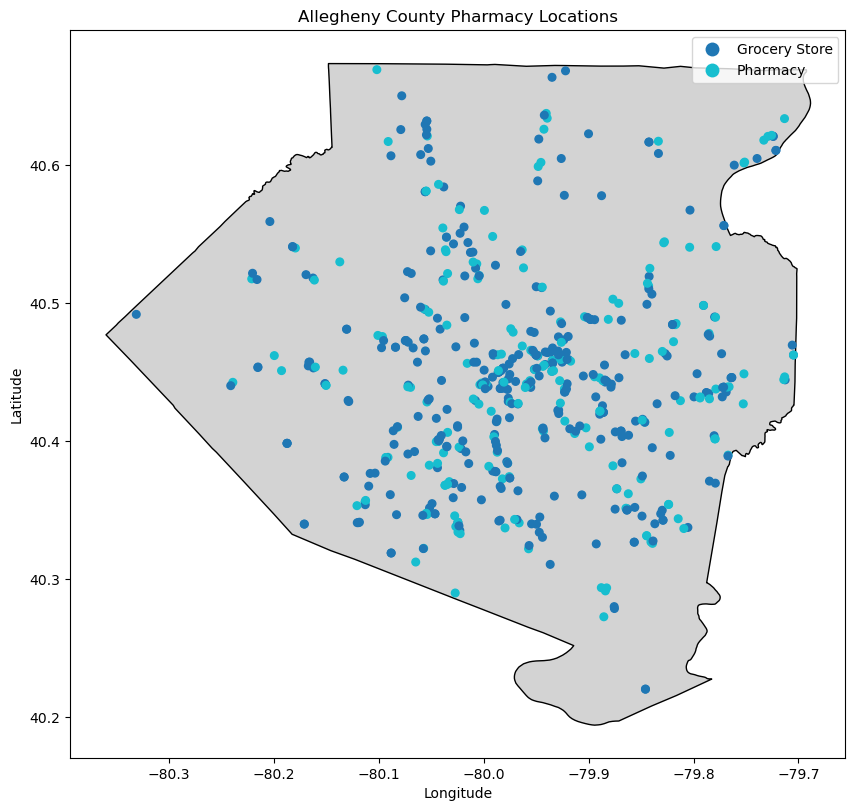

In [160]:
allegheny_map = gpd.read_file("AlleghenyCountyBoundary.geojson")

# Check and set CRS for landmarks
gdf_landmarks = gpd.GeoDataFrame(df_active, geometry=gpd.points_from_xy(df_active.point_x, df_active.point_y), crs = "EPSG:2272")
gdf_landmarks = gdf_landmarks.to_crs(epsg = 4326)

# Plot map
fig, ax = plt.subplots(figsize=(10, 10))
allegheny_map.plot(ax=ax, color='lightgrey', edgecolor='black')  

# Plot landmarks
gdf_landmarks.plot(ax=ax, markersize=30, column='type', cmap='tab10', legend=True)

# Set titles and labels
plt.title("Allegheny County Pharmacy Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Adding census blocks to the map

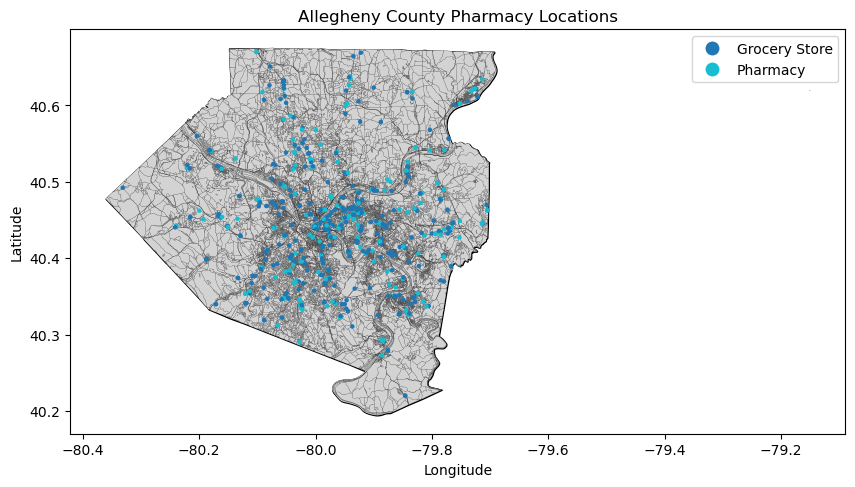

In [162]:
census_blocks = gpd.read_file("AlleghenyCountyCensusBlocks2021.shp")

# Check and set CRS for landmarks and census
gdf_landmarks = gpd.GeoDataFrame(df_active, geometry=gpd.points_from_xy(df_active.point_x, df_active.point_y), crs = "EPSG:2272")
gdf_landmarks = gdf_landmarks.to_crs(epsg = 4326)

# Plot map
fig, ax = plt.subplots(figsize=(10, 10))
allegheny_map.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot county boundary

# Plot census blocks
census_blocks.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1)

# Plot landmarks
gdf_landmarks.plot(ax=ax, markersize=5, column='type', cmap='tab10', legend=True)


# Titles and labels
plt.title("Allegheny County Pharmacy Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## **Current Pharmacy Deserts** 

We define a pharmacy desert as an area that contains no pharmacy or bus stop within 1 mile of the centroid of a census block. We used KDTree to quickly find the closest pharmacy to each census block centroid. The KDTree organizes pharmacy locations efficiently, allowing us to calculate distances without checking every point manually. The next two visualizations show the current pharmacy deserts in Allegheny County:

- The first map considers only pharmacy deserts in relation to census blocks.
- The second map includes bus routes and stops and shows the pharmacy desert when combining both factors.

**Green** means there is a pharmacy within 1 mile of the centroid or bus stop.

**Red** means there not a pharmacy within 1 mile of the centroid or bus stop and is therefore a pharmacy desert.

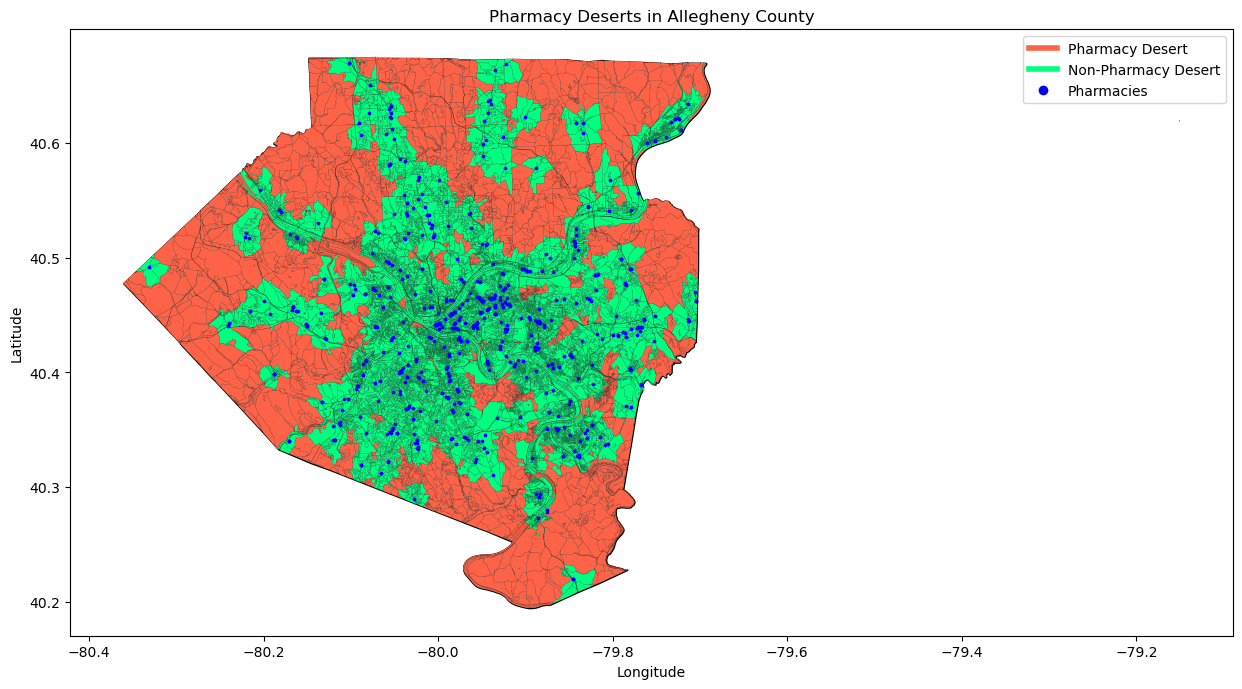

In [164]:
#Calculate centroids for census block
census_blocks['centroid'] = census_blocks.geometry.centroid

# Extract pharmacy locations as (longitude, latitude) tuples
pharmacy_coords = np.array([(point.x, point.y) for point in gdf_landmarks.geometry])

#Extract centroids as (longitude, latitude) tuples
centroid_coords = np.array([(point.x, point.y) for point in census_blocks['centroid']])

# Build a KDTree for pharmacies
pharmacy_tree = KDTree(pharmacy_coords)

# Query the nearest pharmacy for each centroid
distances, _ = pharmacy_tree.query(centroid_coords, k=1)

# Convert distances from degrees to miles (1 degree of latitude corresponds approximately to 69 miles on Earth's surface)
distances_in_miles = distances * 69

# Add distances to census blocks
census_blocks['min_distance_to_pharmacy'] = distances_in_miles

# Identify pharmacy deserts
census_blocks['is_pharmacy_desert'] = census_blocks['min_distance_to_pharmacy'] > 1

# Visualize pharmacy deserts
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Allegheny County boundary 
allegheny_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot census blocks 
custom_cmap = ListedColormap(['springgreen', 'tomato'])
census_blocks.plot(
    ax=ax,
    column='is_pharmacy_desert',  
    cmap=custom_cmap,  
    legend=True,
    edgecolor='black',
    linewidth=0.1,
)

# Plot pharmacy locations
gdf_landmarks.plot(ax=ax, color='blue', markersize=3, label='Pharmacies')

pharmacy_desert_patch = mlines.Line2D([], [], color='tomato', lw=4, label='Pharmacy Desert')
non_pharmacy_desert_patch = mlines.Line2D([], [], color='springgreen', lw=4, label='Non-Pharmacy Desert')
pharmacy_marker = plt.Line2D([0], [0], marker='o', color='w', label='Pharmacies', markerfacecolor='blue', markersize=8)

# custom legend
ax.legend(handles=[pharmacy_desert_patch, non_pharmacy_desert_patch, pharmacy_marker])

plt.title("Pharmacy Deserts in Allegheny County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Computing the number of pharmacy deserts if we only include the distance to pharmacies

In [166]:
pharmacy_desert_count = census_blocks['is_pharmacy_desert'].sum()

print("Number of Pharmacy Deserts:", pharmacy_desert_count)

Number of Pharmacy Deserts: 3966


### Adding bus stops to our map

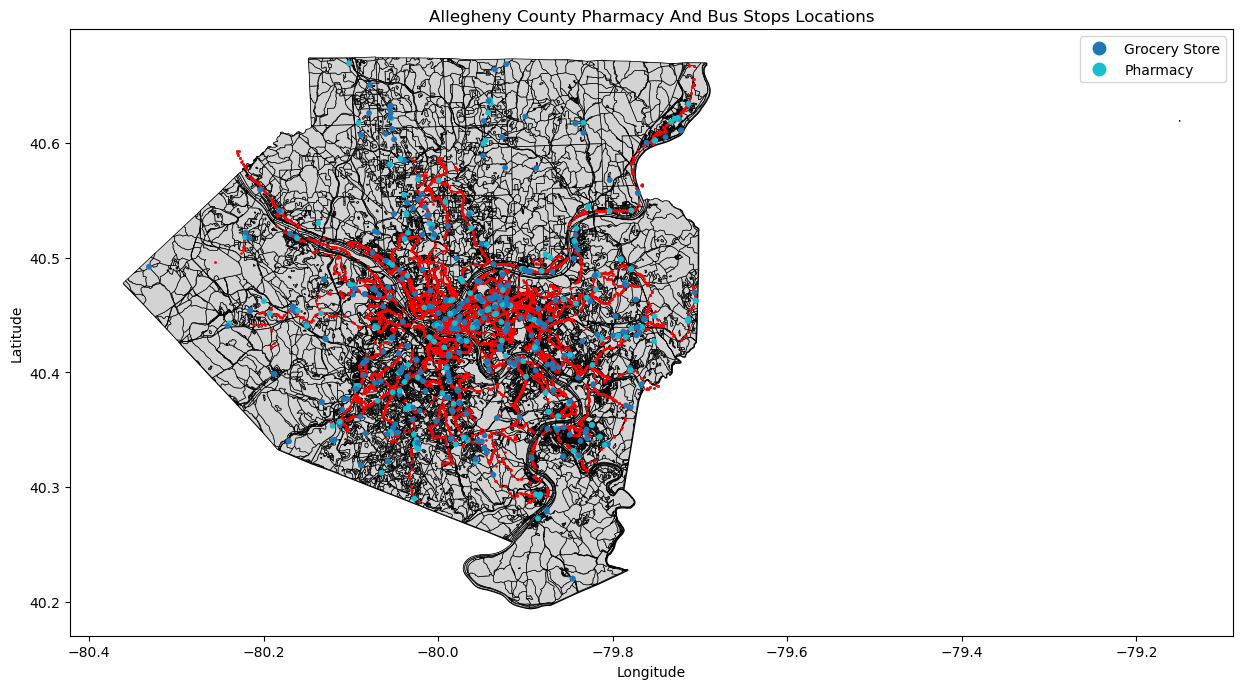

In [168]:
bus_stops = gpd.read_file("BusStops.geojson")

# Check and set CRS for landmarks and census
gdf_landmarks = gpd.GeoDataFrame(df_active, geometry=gpd.points_from_xy(df_active.point_x, df_active.point_y), crs = "EPSG:2272")
gdf_landmarks = gdf_landmarks.to_crs(epsg = 4326)

census_blocks = census_blocks.set_crs("EPSG:4326")
census_blocks = census_blocks.to_crs(epsg = 4326)

# Plot map
fig, ax = plt.subplots(figsize=(15, 10))
allegheny_map.plot(ax=ax, color='lightgrey', edgecolor='black') 

# Plot census blocks
census_blocks.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

# Plot bus stops
bus_stops.plot(ax=ax, color='red', markersize=1)

# Plot landmarks
gdf_landmarks.plot(ax=ax, markersize=10, column='type', cmap='tab10', legend=True)

# titles and labels
plt.title("Allegheny County Pharmacy And Bus Stops Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Combining both centroid and bus stop analysis to create new pharmacy desert locations

C:\Users\Maggie\AppData\Local\Temp\ipykernel_26504\2787789006.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_blocks['centroid'] = census_blocks.geometry.centroid


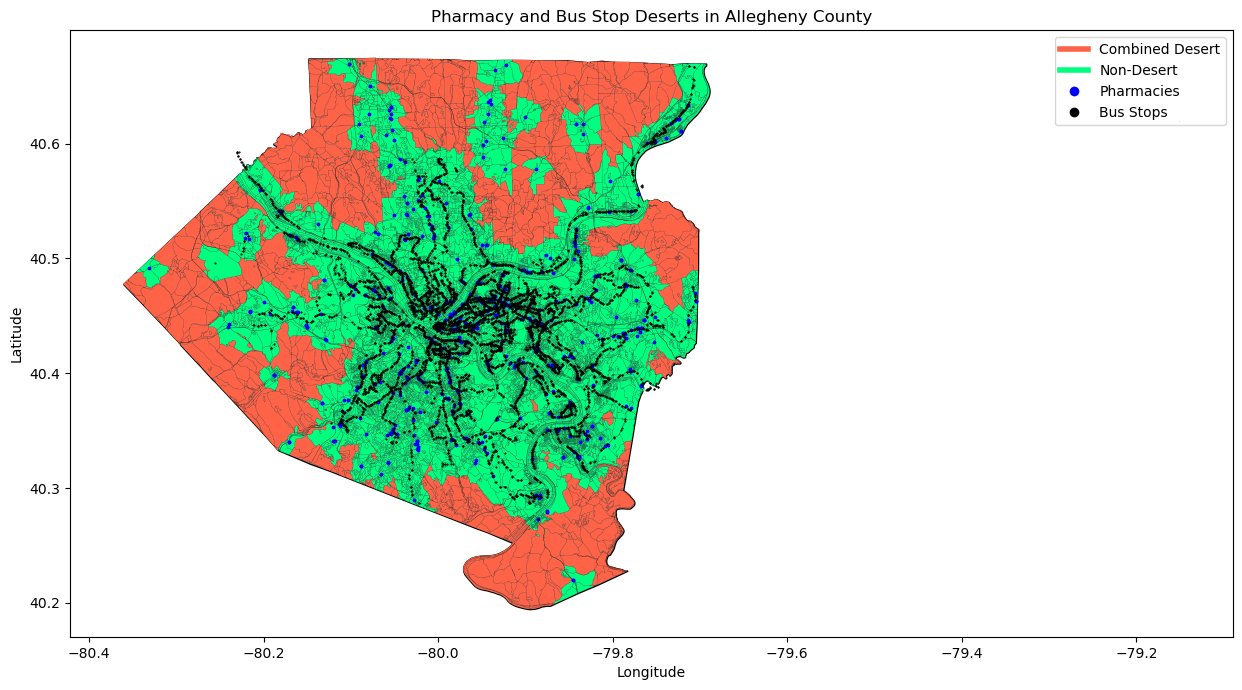

In [170]:
# Ensure CRS consistency
gdf_landmarks = gdf_landmarks.to_crs(epsg=4326)
bus_stops = bus_stops.to_crs(epsg=4326)
census_blocks = census_blocks.to_crs(epsg=4326)

# Calculate centroids for census blocks
census_blocks['centroid'] = census_blocks.geometry.centroid

# Extract coordinates for pharmacies, bus stops, and census block centroids
pharmacy_coords = np.array([(point.x, point.y) for point in gdf_landmarks.geometry])
bus_stop_coords = np.array([(point.x, point.y) for point in bus_stops.geometry])
centroid_coords = np.array([(point.x, point.y) for point in census_blocks['centroid']])

# Build KDTree for pharmacies and bus stops
pharmacy_tree = KDTree(pharmacy_coords)
bus_stop_tree = KDTree(bus_stop_coords)

# Query nearest distances
pharmacy_distances, _ = pharmacy_tree.query(centroid_coords, k=1)
bus_stop_distances, _ = bus_stop_tree.query(centroid_coords, k=1)

# Convert distances from degrees to miles (1 degree ~ 69 miles)
pharmacy_distances_in_miles = pharmacy_distances * 69
bus_stop_distances_in_miles = bus_stop_distances * 69

# Add distances to census blocks
census_blocks['min_distance_to_pharmacy'] = pharmacy_distances_in_miles
census_blocks['min_distance_to_bus_stop'] = bus_stop_distances_in_miles

# Identify combined deserts (both > 1 mile)
census_blocks['is_combined_desert'] = (
    (census_blocks['min_distance_to_pharmacy'] > 1) & 
    (census_blocks['min_distance_to_bus_stop'] > 1)
)

# Visualize the combined pharmacy deserts
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Allegheny County boundary
allegheny_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot census blocks 
custom_cmap = ListedColormap(['springgreen', 'tomato'])  # Green for non-deserts, red for deserts
census_blocks.plot(
    ax=ax,
    column='is_combined_desert',
    cmap=custom_cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.1,
)

# Plot pharmacy locations
gdf_landmarks.plot(ax=ax, color='blue', markersize=3, label='Pharmacies', marker='o')

# Plot bus stops
bus_stops.plot(ax=ax, color='black', markersize=0.25, label='Bus Stops', marker='o')

# add custom legend
combined_desert_patch = mlines.Line2D([], [], color='tomato', lw=4, label='Combined Desert')
non_desert_patch = mlines.Line2D([], [], color='springgreen', lw=4, label='Non-Desert')
pharmacy_marker = plt.Line2D([0], [0], marker='o', color='w', label='Pharmacies', markerfacecolor='blue', markersize=8)
bus_stop_marker = plt.Line2D([0], [0], marker='o', color='w', label='Bus Stops', markerfacecolor='black', markersize=8)

ax.legend(handles=[combined_desert_patch, non_desert_patch, pharmacy_marker, bus_stop_marker])

# Titles and labels
plt.title("Pharmacy and Bus Stop Deserts in Allegheny County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Computing the number of pharmacy deserts if we include bus stops

In [172]:
combined_desert_count = census_blocks['is_combined_desert'].sum()

print("Number of Combined Pharmacy and Bus Stop Deserts:", combined_desert_count)

Number of Combined Pharmacy and Bus Stop Deserts: 2165


### Making a table that shows for each census block whether it is a pharmacy

In [174]:
# Add a unique identifier column
census_blocks['Census Block ID'] = range(1, len(census_blocks) + 1)

# Select relevant columns to create the table
desert_table = census_blocks[['Census Block ID', 'min_distance_to_pharmacy', 'min_distance_to_bus_stop', 'is_combined_desert']]

# Renaming columns
desert_table = desert_table.rename(columns={
    'min_distance_to_pharmacy': 'Distance to Nearest Pharmacy (miles)',
    'min_distance_to_bus_stop': 'Distance to Nearest Bus Stop (miles)',
    'is_combined_desert': 'Is Pharmacy Desert (Yes/No)'
})

desert_table['Is Pharmacy Desert (Yes/No)'] = desert_table['Is Pharmacy Desert (Yes/No)'].apply(lambda x: 'Yes' if x else 'No')
desert_table.to_csv('pharmacy_deserts.csv', index=False)

# Preview 
desert_table.head(1815)



Census Block ID  Distance to Nearest Pharmacy (miles)  \
0                   1                              0.569281   
1                   2                              0.254752   
2                   3                              0.827825   
3                   4                              0.645264   
4                   5                              0.864463   
...               ...                                   ...   
1810             1811                              1.501213   
1811             1812                              1.265060   
1812             1813                              1.850086   
1813             1814                              1.378798   
1814             1815                              1.486698   

      Distance to Nearest Bus Stop (miles) Is Pharmacy Desert (Yes/No)  
0                                 0.070680                          No  
1                                 0.299977                          No  
2                                 0.415616                          No  
3                                 0.396226                          No  
4                                 0.258249                          No  
...                                    ...                         ...  
1810                              1.216727                         Yes  
1811                              0.775646                          No  
1812                              1.945783                         Yes  
1813                              1.124585                         Yes  
1814                              1.850012                         Yes  

[1815 rows x 4 columns]

## **Adding Predictors into our Dataframe**

We will consider the following as possbile predictors or pharmacy deserts
- Race
- Population male vs female
- Age
- Race
- Environmental justice area
- Housing Conditions 
- Walk Scores

#### Census data contains total population, population density, population male vs female, age, and race

In [177]:
# reading in census data
census = pd.read_csv('census_2010_all.csv')
census.head(50)

Area Name-Legal/Statistical Area Description  \
0                                    Block 1000   
1                                    Block 1001   
2                                    Block 1002   
3                                    Block 1003   
4                                    Block 1004   
5                                    Block 1005   
6                                    Block 1006   
7                                    Block 1007   
8                                    Block 1008   
9                                    Block 1009   
10                                   Block 1010   
11                                   Block 1011   
12                                   Block 1012   
13                                   Block 1013   
14                                   Block 1014   
15                                   Block 1015   
16                                   Block 1016   
17                                   Block 1017   
18                                   Block 1018   
19                                   Block 1019   
20                                   Block 1020   
21                                   Block 1021   
22                                   Block 1022   
23                                   Block 1023   
24                                   Block 1024   
25                                   Block 1025   
26                                   Block 1026   
27                                   Block 1027   
28                                   Block 1028   
29                                   Block 1029   
30                                   Block 1030   
31                                   Block 1031   
32                                   Block 2000   
33                                   Block 2001   
34                                   Block 2002   
35                                   Block 2003   
36                                   Block 2004   
37                                   Block 2005   
38                                   Block 2006   
39                                   Block 2007   
40                                   Block 2008   
41                                   Block 2009   
42                                   Block 2010   
43                                   Block 2011   
44                                   Block 2012   
45                                   Block 2013   
46                                   Block 2014   
47                                   Block 2015   
48                                   Block 2016   
49                                   Block 2017   

                                      Qualifying Name  Census Tract  \
0   Block 1000, Block Group 1, Census Tract 103, A...         10300   
1   Block 1001, Block Group 1, Census Tract 103, A...         10300   
2   Block 1002, Block Group 1, Census Tract 103, A...         10300   
3   Block 1003, Block Group 1, Census Tract 103, A...         10300   
4   Block 1004, Block Group 1, Census Tract 103, A...         10300   
5   Block 1005, Block Group 1, Census Tract 103, A...         10300   
6   Block 1006, Block Group 1, Census Tract 103, A...         10300   
7   Block 1007, Block Group 1, Census Tract 103, A...         10300   
8   Block 1008, Block Group 1, Census Tract 103, A...         10300   
9   Block 1009, Block Group 1, Census Tract 103, A...         10300   
10  Block 1010, Block Group 1, Census Tract 103, A...         10300   
11  Block 1011, Block Group 1, Census Tract 103, A...         10300   
12  Block 1012, Block Group 1, Census Tract 103, A...         10300   
13  Block 1013, Block Group 1, Census Tract 103, A...         10300   
14  Block 1014, Block Group 1, Census Tract 103, A...         10300   
15  Block 1015, Block Group 1, Census Tract 103, A...         10300   
16  Block 1016, Block Group 1, Census Tract 103, A...         10300   
17  Block 1017, Block Group 1, Census Tract 103, A...         10300   
18  Block 1018, Block Group 1, Census Tract 103, A..

#### Environmental Justice area data tells us if a census tract has 20% of the population living in poverty and/or 30% or more of the population is a minority

In [179]:
# Reading in environmental justice area data
eja_data = pd.read_csv('EnvironmentalJusticeAreas.csv')
eja_data = eja_data.drop(columns=['_id', 'FID'])
eja_data

TRACT  EJ_Area
0     20300        0
1     40400        1
2     70900        1
3    110200        1
4    140500        1
..      ...      ...
388  486700        1
389  504100        1
390   10300        1
391   50900        1
392  101800        0

[393 rows x 2 columns]

#### Housing condition tells us an estimated percentage of distressed housing units in a census tract

In [181]:
# Reading in housing conditions data
housing_condition = pd.read_csv('PoorHousingConditions.csv')
housing_condition = housing_condition.drop(columns=['_id'])
housing_condition

TRACT  PPoorCon
0    431100  0.022593
1    432300  0.015898
2    563800  0.016079
3    563300  0.018003
4    451104  0.009339
..      ...       ...
397       0  0.000000
398       0  0.000000
399       0  0.000000
400       0  0.000000
401       0  0.000000

[402 rows x 2 columns]

#### Walk scores are determined by the distance amenities are from a census tract centroid. Amenities within a 5 minute walk (0.25 miles are awarded a walk score of 100. Amenities farther than a 30 minute walk are awarded a 0 score

In [183]:
# Reading in walk scores data
walk_scores = pd.read_csv('WalkScore_CensusTract.csv')
walk_scores

Census Tract  Walk Score
0           10300          82
1           20100         100
2           20300          83
3           30500          77
4           40200          71
..            ...         ...
397        981000          54
398        981100          51
399        981200          75
400        981800          35
401        982200          82

[402 rows x 2 columns]

In [184]:
#choosing the columns we want to use
census = census[['Census Tract', 'Census Block ID', 'Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone']]
census.head()

Census Tract  Census Block ID  Total Population  \
0         10300             1000                 0   
1         10300             1001                 0   
2         10300             1002                 0   
3         10300             1003                 0   
4         10300             1004                 0   

   Population Density (per sq. mile)  Total Population: Male  \
0                                0.0                     0.0   
1                                0.0                     0.0   
2                                0.0                     0.0   
3                                0.0                     0.0   
4                                0.0                     0.0   

   Total Population: Female  Total Population: 18 to 24 years  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   

   Total Population: 25 to 34 years  Total Population: 35 to 44 years  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

   Total Population: 45 to 54 years  Total Population: 55 to 64 years  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

   Total Population: 65 and 74 years  Total Population: 75 to 84 years  \
0                                0.0                               0.0   
1                                0.0                               0.0   
2                                0.0                               0.0   
3                                0.0                               0.0   
4                                0.0                               0.0   

   Total Population: 85 years and over  Total population: White alone  \
0                                  0.0                            0.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                                  0.0                            0.0   
4                                  0.0                            0.0   

   Total population: Black or African American alone  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   Total population: Asian alone  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0

In [185]:
# Removing any census block that has no population
census_cleaned = census[census["Total Population"] > 0]
census_cleaned

Census Tract  Census Block ID  Total Population  \
7             10300             1007              2594   
34            10300             2002                69   
47            10300             2015               605   
48            10300             2016              2662   
55            10300             3001                 1   
...             ...              ...               ...   
30503        982200             1003                 1   
30505        982200             1005               884   
30507        982200             1007                47   
30512        982200             1012                92   
30515        982200             1015              3088   

       Population Density (per sq. mile)  Total Population: Male  \
7                            159212.0000                0.902082   
34                            19410.1400                0.318841   
47                            67537.7300                0.368595   
48                            84912.4100                0.414350   
55                              415.0622                0.000000   
...                                  ...                     ...   
30503                           131.6988                0.000000   
30505                         24513.1200                0.489819   
30507                          4483.5890                1.000000   
30512                         16198.4300                0.489130   
30515                        210953.6000                0.364637   

       Total Population: Female  Total Population: 18 to 24 years  \
7                      0.097918                          0.277564   
34                     0.681159                          0.101449   
47                     0.631405                          0.990083   
48                     0.585650                          0.990609   
55                     1.000000                          0.000000   
...                         ...                               ...   
30503                  1.000000                          1.000000   
30505                  0.510181                          1.000000   
30507                  0.000000                          1.000000   
30512                  0.510870                          1.000000   
30515                  0.635363                          0.998057   

       Total Population: 25 to 34 years  Total Population: 35 to 44 years  \
7                              0.323439                          0.211642   
34                             0.086957                          0.333333   
47                             0.008264                          0.000000   
48                             0.003381                          0.000376   
55                             0.000000                          0.000000   
...                                 ...                               ...   
30503                          0.000000                          0.000000   
30505                          0.000000                          0.000000   
30507                          0.000000                          0.000000   
30512                          0.000000                          0.000000   
30515                          0.000324                          0.000000   

       Total Population: 45 to 54 years  Total Population: 55 to 64 years  \
7                              0.142251                          0.034310   
34                             0.289855                          0.173913   
47                             0.001653                          0.000000   
48                             0.000751                          0.001127   
55                             1.000000                          0.000000   
...                                 ...                               ...   
30503                          0.000000                          0.000000   
30505                          0.000000                          0.000000   
30507                          0.000000       

In [186]:
# Merging environmental justice area dataset with census data
eja_data = eja_data.rename(columns = {"TRACT": "Census Tract",})
merged_eja= pd.merge(census_cleaned, eja_data, on='Census Tract', how='inner')

# Merging housing conditions with census data
housing_condition = housing_condition.rename(columns = {"TRACT": "Census Tract"})
merged_eja_housing = pd.merge(merged_eja, housing_condition, on='Census Tract', how='inner')
merged_eja_housing

# Merging walk scores with census data
merged_eja_house_walk = pd.merge(merged_eja_housing, walk_scores, on='Census Tract', how='inner')
merged_eja_house_walk

# Merging all data with desert table
merged_data = pd.merge(merged_eja_house_walk, desert_table, on='Census Block ID', how='inner')
merged_data



Census Tract  Census Block ID  Total Population  \
0             10300             1007              2594   
1             10300             2002                69   
2             10300             2015               605   
3             10300             2016              2662   
4             10300             3001                 1   
...             ...              ...               ...   
21909        982200             1003                 1   
21910        982200             1005               884   
21911        982200             1007                47   
21912        982200             1012                92   
21913        982200             1015              3088   

       Population Density (per sq. mile)  Total Population: Male  \
0                            159212.0000                0.902082   
1                             19410.1400                0.318841   
2                             67537.7300                0.368595   
3                             84912.4100                0.414350   
4                               415.0622                0.000000   
...                                  ...                     ...   
21909                           131.6988                0.000000   
21910                         24513.1200                0.489819   
21911                          4483.5890                1.000000   
21912                         16198.4300                0.489130   
21913                        210953.6000                0.364637   

       Total Population: Female  Total Population: 18 to 24 years  \
0                      0.097918                          0.277564   
1                      0.681159                          0.101449   
2                      0.631405                          0.990083   
3                      0.585650                          0.990609   
4                      1.000000                          0.000000   
...                         ...                               ...   
21909                  1.000000                          1.000000   
21910                  0.510181                          1.000000   
21911                  0.000000                          1.000000   
21912                  0.510870                          1.000000   
21913                  0.635363                          0.998057   

       Total Population: 25 to 34 years  Total Population: 35 to 44 years  \
0                              0.323439                          0.211642   
1                              0.086957                          0.333333   
2                              0.008264                          0.000000   
3                              0.003381                          0.000376   
4                              0.000000                          0.000000   
...                                 ...                               ...   
21909                          0.000000                          0.000000   
21910                          0.000000                          0.000000   
21911                          0.000000                          0.000000   
21912                          0.000000                          0.000000   
21913                          0.000324                          0.000000   

       Total Population: 45 to 54 years  ...  \
0                              0.142251  ...   
1                              0.289855  ...   
2                              0.001653  ...   
3                              0.000751  ...   
4                              1.000000  ...   
...                                 ...  ...   
21909                          0.000000  ...   
21910                          0.000000  ...   
21911                          0.000000  ...   
21912                          0.000000  ...   
21913                          0.000000  ...   

       Total Population: 85 years and over  Total population: White alone  \
0                                 0.000771                       0.383963   
1       

## **Cleaning New Dataframe with Possible Predictors** 

In [188]:
merged_data.dtypes

Census Tract                                           int64
Census Block ID                                        int64
Total Population                                       int64
Population Density (per sq. mile)                    float64
Total Population: Male                               float64
Total Population: Female                             float64
Total Population: 18 to 24 years                     float64
Total Population: 25 to 34 years                     float64
Total Population: 35 to 44 years                     float64
Total Population: 45 to 54 years                     float64
Total Population: 55 to 64 years                     float64
Total Population: 65 and 74 years                    float64
Total Population: 75 to 84 years                     float64
Total Population: 85 years and over                  float64
Total population: White alone                        float64
Total population: Black or African American alone    float64
Total population: Asian 

In [189]:
merged_data.describe

<bound method NDFrame.describe of        Census Tract  Census Block ID  Total Population  \
0             10300             1007              2594   
1             10300             2002                69   
2             10300             2015               605   
3             10300             2016              2662   
4             10300             3001                 1   
...             ...              ...               ...   
21909        982200             1003                 1   
21910        982200             1005               884   
21911        982200             1007                47   
21912        982200             1012                92   
21913        982200             1015              3088   

       Population Density (per sq. mile)  Total Population: Male  \
0                            159212.0000                0.902082   
1                             19410.1400                0.318841   
2                             67537.7300                0.368595 

In [190]:
merged_data.isnull().sum()

Census Tract                                         0
Census Block ID                                      0
Total Population                                     0
Population Density (per sq. mile)                    0
Total Population: Male                               0
Total Population: Female                             0
Total Population: 18 to 24 years                     0
Total Population: 25 to 34 years                     0
Total Population: 35 to 44 years                     0
Total Population: 45 to 54 years                     0
Total Population: 55 to 64 years                     0
Total Population: 65 and 74 years                    0
Total Population: 75 to 84 years                     0
Total Population: 85 years and over                  0
Total population: White alone                        0
Total population: Black or African American alone    0
Total population: Asian alone                        0
EJ_Area                                              0
PPoorCon  

In [191]:
merged_data.head()

Census Tract  Census Block ID  Total Population  \
0         10300             1007              2594   
1         10300             2002                69   
2         10300             2015               605   
3         10300             2016              2662   
4         10300             3001                 1   

   Population Density (per sq. mile)  Total Population: Male  \
0                        159212.0000                0.902082   
1                         19410.1400                0.318841   
2                         67537.7300                0.368595   
3                         84912.4100                0.414350   
4                           415.0622                0.000000   

   Total Population: Female  Total Population: 18 to 24 years  \
0                  0.097918                          0.277564   
1                  0.681159                          0.101449   
2                  0.631405                          0.990083   
3                  0.585650                          0.990609   
4                  1.000000                          0.000000   

   Total Population: 25 to 34 years  Total Population: 35 to 44 years  \
0                          0.323439                          0.211642   
1                          0.086957                          0.333333   
2                          0.008264                          0.000000   
3                          0.003381                          0.000376   
4                          0.000000                          0.000000   

   Total Population: 45 to 54 years  ...  Total Population: 85 years and over  \
0                          0.142251  ...                             0.000771   
1                          0.289855  ...                             0.000000   
2                          0.001653  ...                             0.000000   
3                          0.000751  ...                             0.000000   
4                          1.000000  ...                             0.000000   

   Total population: White alone  \
0                       0.383963   
1                       0.405797   
2                       0.928926   
3                       0.908340   
4                       0.000000   

   Total population: Black or African American alone  \
0                                           0.611796   
1                                           0.449275   
2                                           0.034711   
3                                           0.042825   
4                                           1.000000   

   Total population: Asian alone  EJ_Area  PPoorCon  Walk Score  \
0                       0.000386        1       0.0          82   
1                       0.000000        1       0.0          82   
2                       0.019835        1       0.0          82   
3                       0.020661        1       0.0          82   
4                       0.000000        1       0.0          82   

   Distance to Nearest Pharmacy (miles)  Distance to Nearest Bus Stop (miles)  \
0                              0.805135                              0.483597   
1                              0.653068                              0.302054   
2                              1.552770                              5.906264   
3                              0.549187                              3.716342   
4                              0.301131                              0.496364   

   Is Pharmacy Desert (Yes/No)  
0                           No  
1                           No  
2                          Yes  
3                           No  
4                           No  

[5 rows x 23 columns]

### Finding outliers
Although there are many outliers in our dataset, we decided to keep them rather than remove them or change the value because it provides us with a whole representation of Allegheny County. It also would not be fair or ethical to remove an outlier because it could be harmful to certain minorities who need equal access to pharmacies

In [193]:
# Identify outliers using the IQR (Interquartile Range) method for numerical columns
numerical_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate IQR for each numerical column and identify outliers
outliers_info = {}
for column in numerical_columns:
    Q1 = merged_data[column].quantile(0.25)
    Q3 = merged_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = merged_data[(merged_data[column] < lower_bound) | (merged_data[column] > upper_bound)]
    outliers_info[column] = outliers.shape[0]

outliers_info

{'Census Tract': 3961,
 'Census Block ID': 131,
 'Total Population': 1878,
 'Population Density (per sq. mile)': 895,
 'Total Population: Male': 1591,
 'Total Population: Female': 1591,
 'Total Population: 18 to 24 years': 947,
 'Total Population: 25 to 34 years': 846,
 'Total Population: 35 to 44 years': 711,
 'Total Population: 45 to 54 years': 764,
 'Total Population: 55 to 64 years': 890,
 'Total Population: 65 and 74 years': 774,
 'Total Population: 75 to 84 years': 1029,
 'Total Population: 85 years and over': 1793,
 'Total population: White alone': 2490,
 'Total population: Black or African American alone': 3264,
 'Total population: Asian alone': 4490,
 'EJ_Area': 0,
 'PPoorCon': 2351,
 'Walk Score': 0,
 'Distance to Nearest Pharmacy (miles)': 312,
 'Distance to Nearest Bus Stop (miles)': 3054}

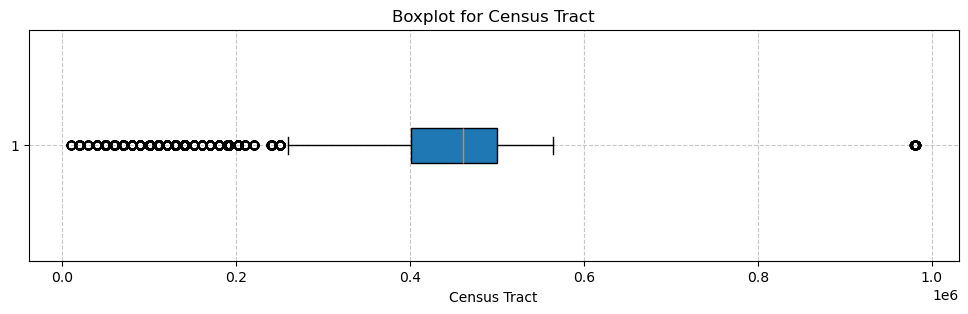

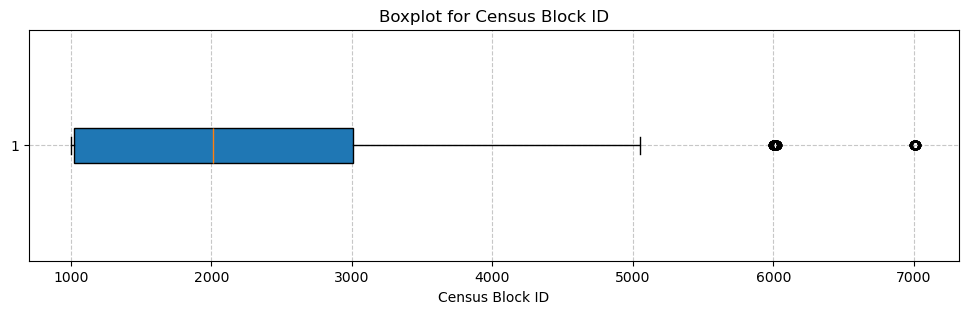

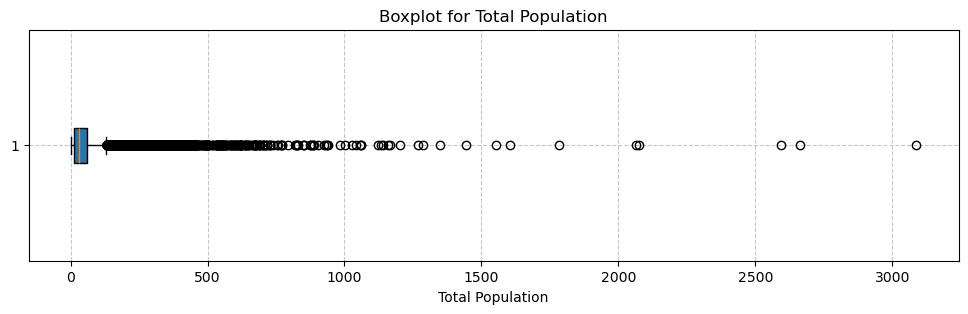

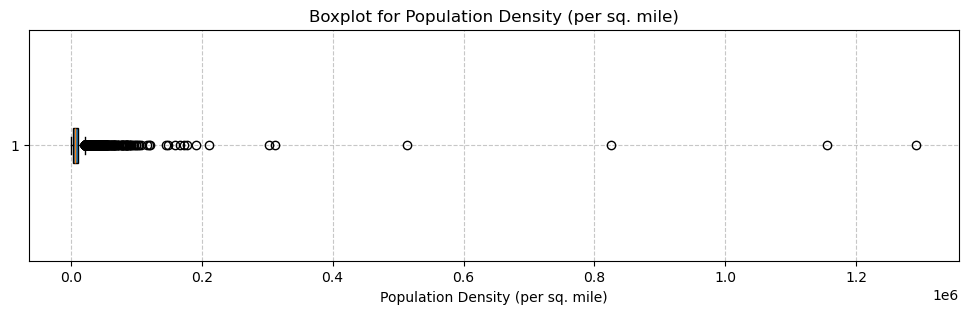

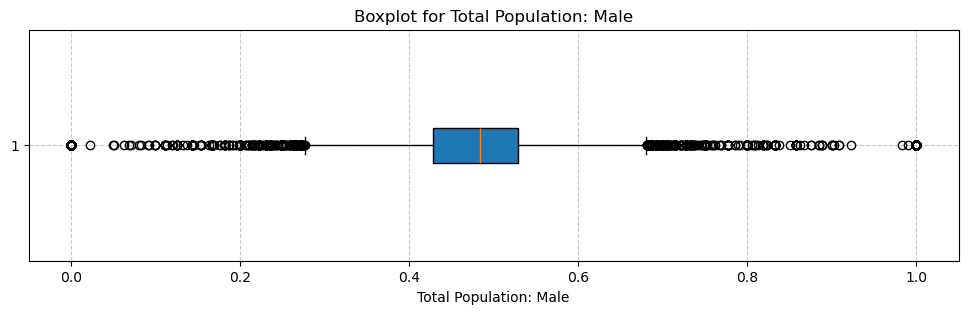

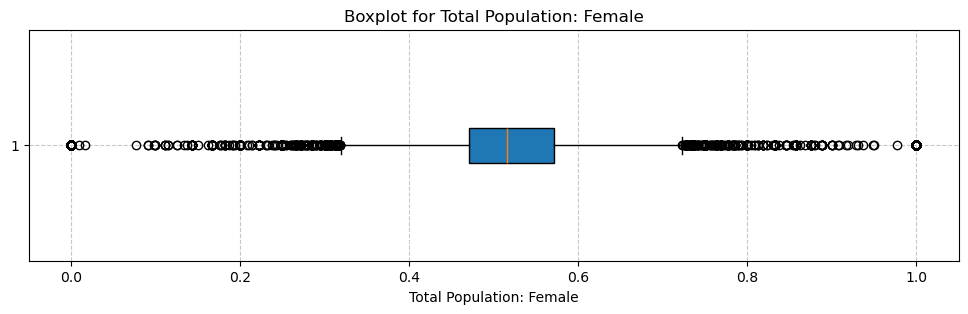

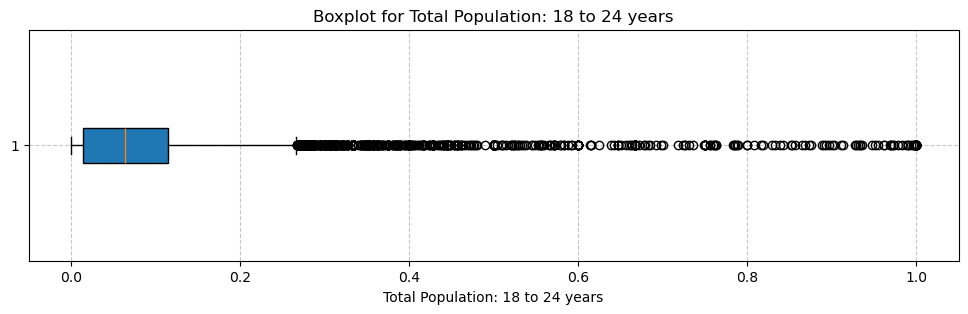

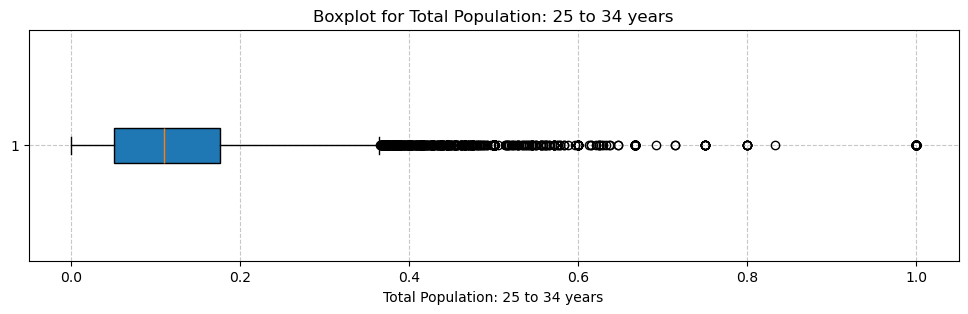

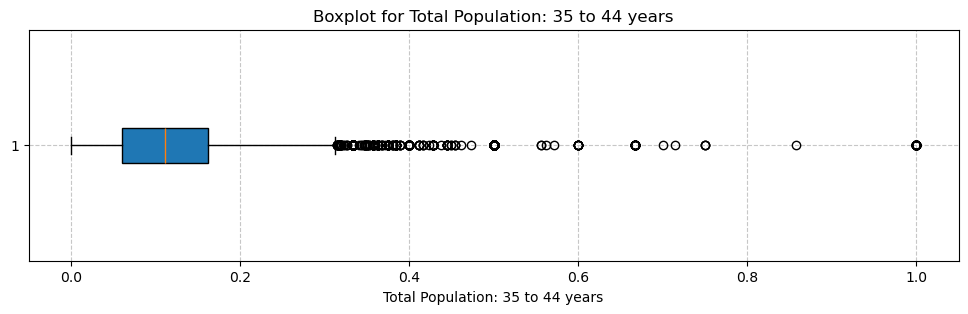

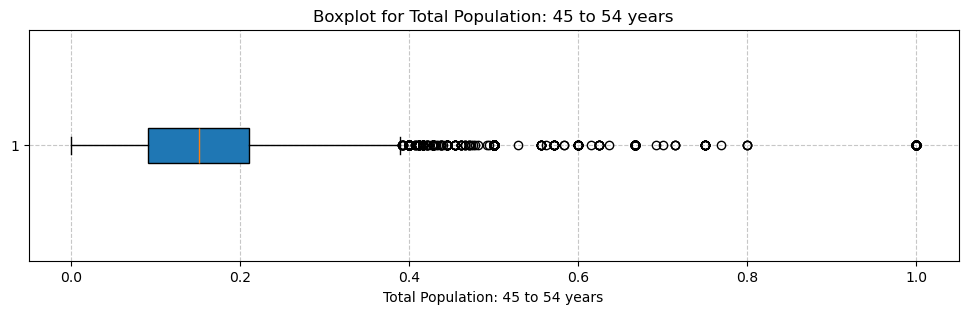

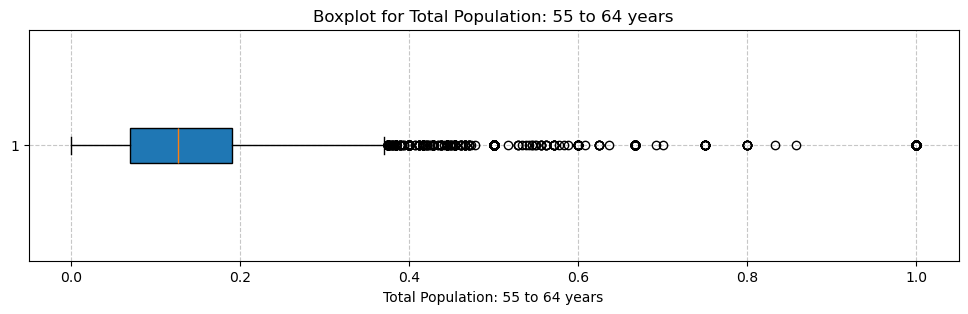

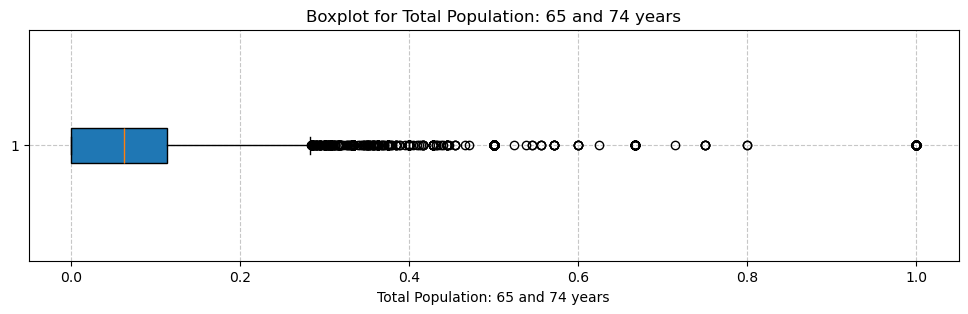

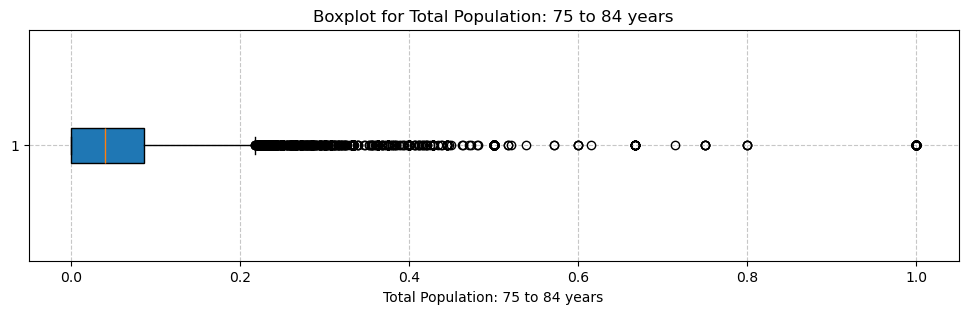

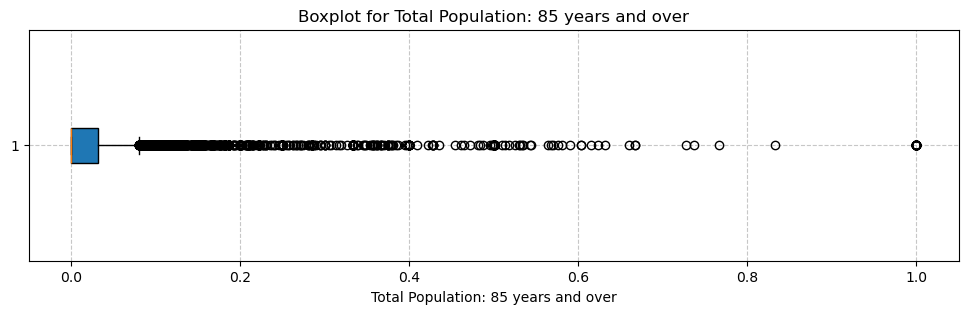

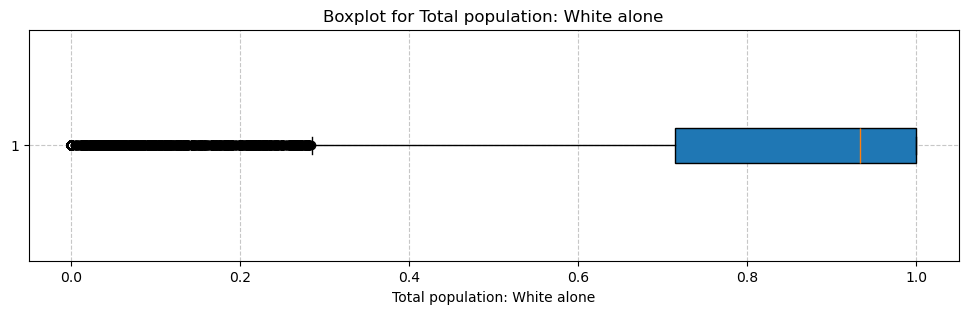

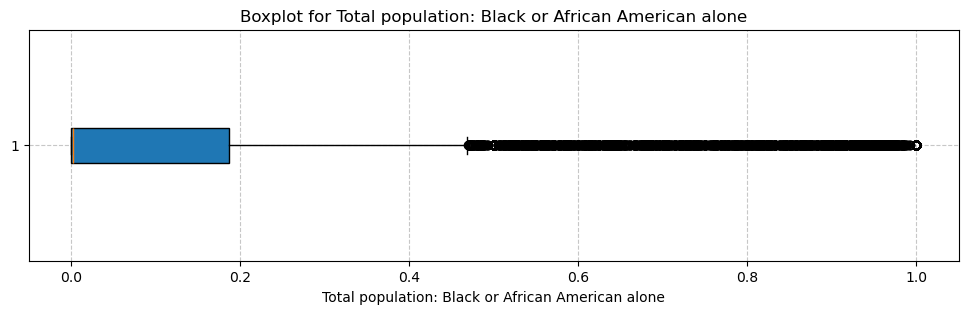

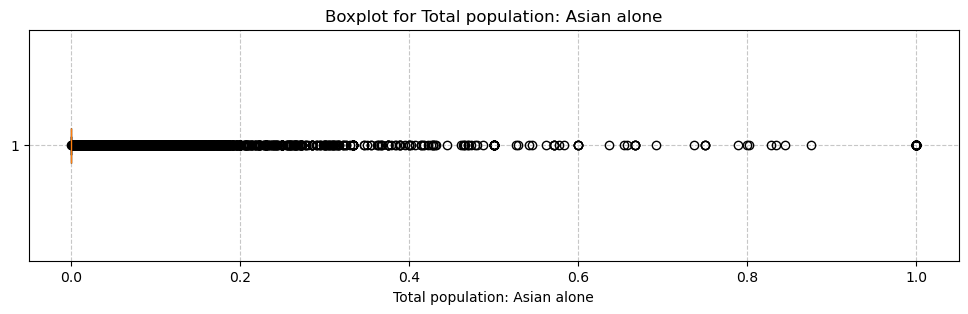

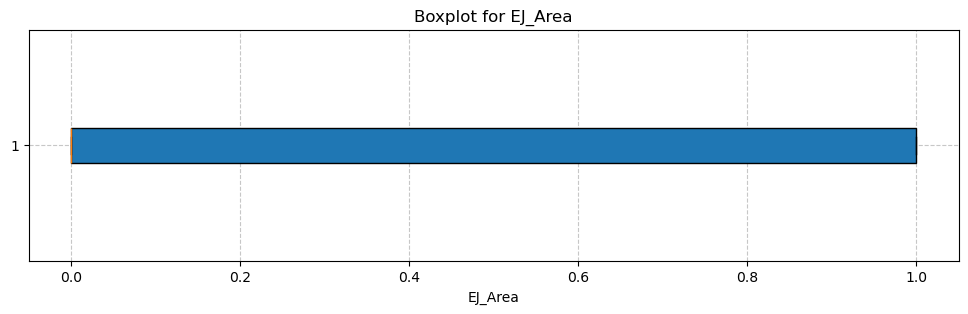

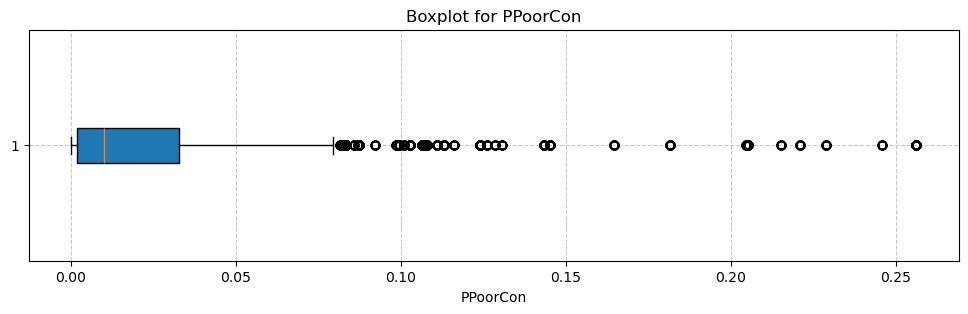

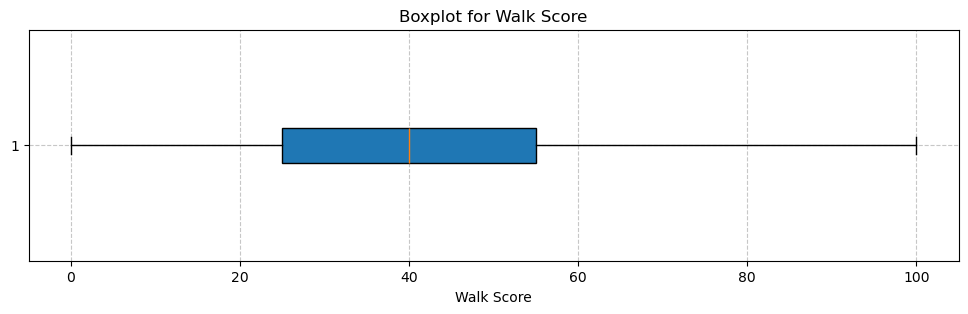

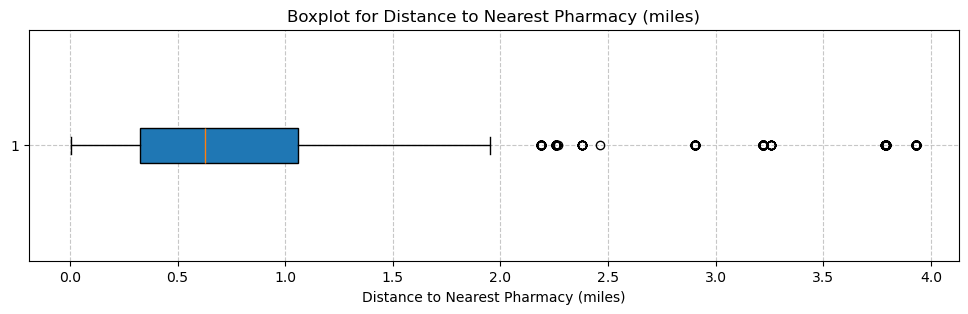

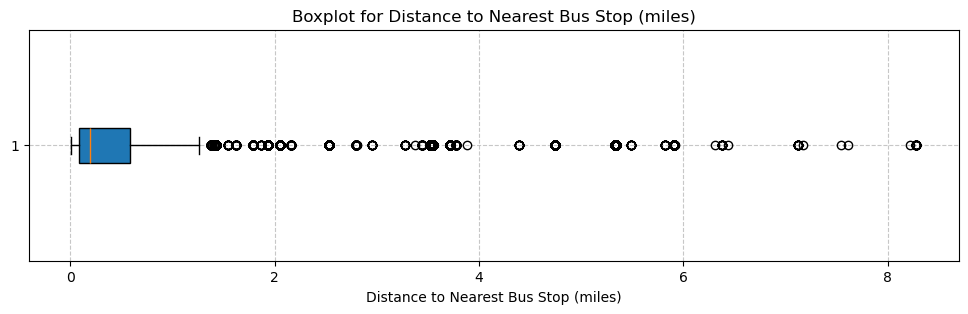

In [194]:
# Identify numerical columns
numerical_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for numerical columns
for column in numerical_columns:
    plt.figure(figsize=(12, 3))
    plt.boxplot(merged_data[column].dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

## **Understanding the Relationships Within our Dataset**

- **Correlation matrix:** visually shows any correlation between features
- **Residual plot:** can determine if relationships between features are non linear. Visualizes distrbution
- **Scatter plot:** can determine if realtionships between features are non linear. Helps visualize how variables interact with each other. Tells us if transformations are needed for modeling
  

## Correlation Matrix:

From our matrix we learned:
- Independent predictors: each predictor contains distinct and unique information
- Multicollinearity: there are no linear relationships therefore our data is nonlinear
- Highlights potential issues: our features might not be sufficient predictors for future pharmacy deserts


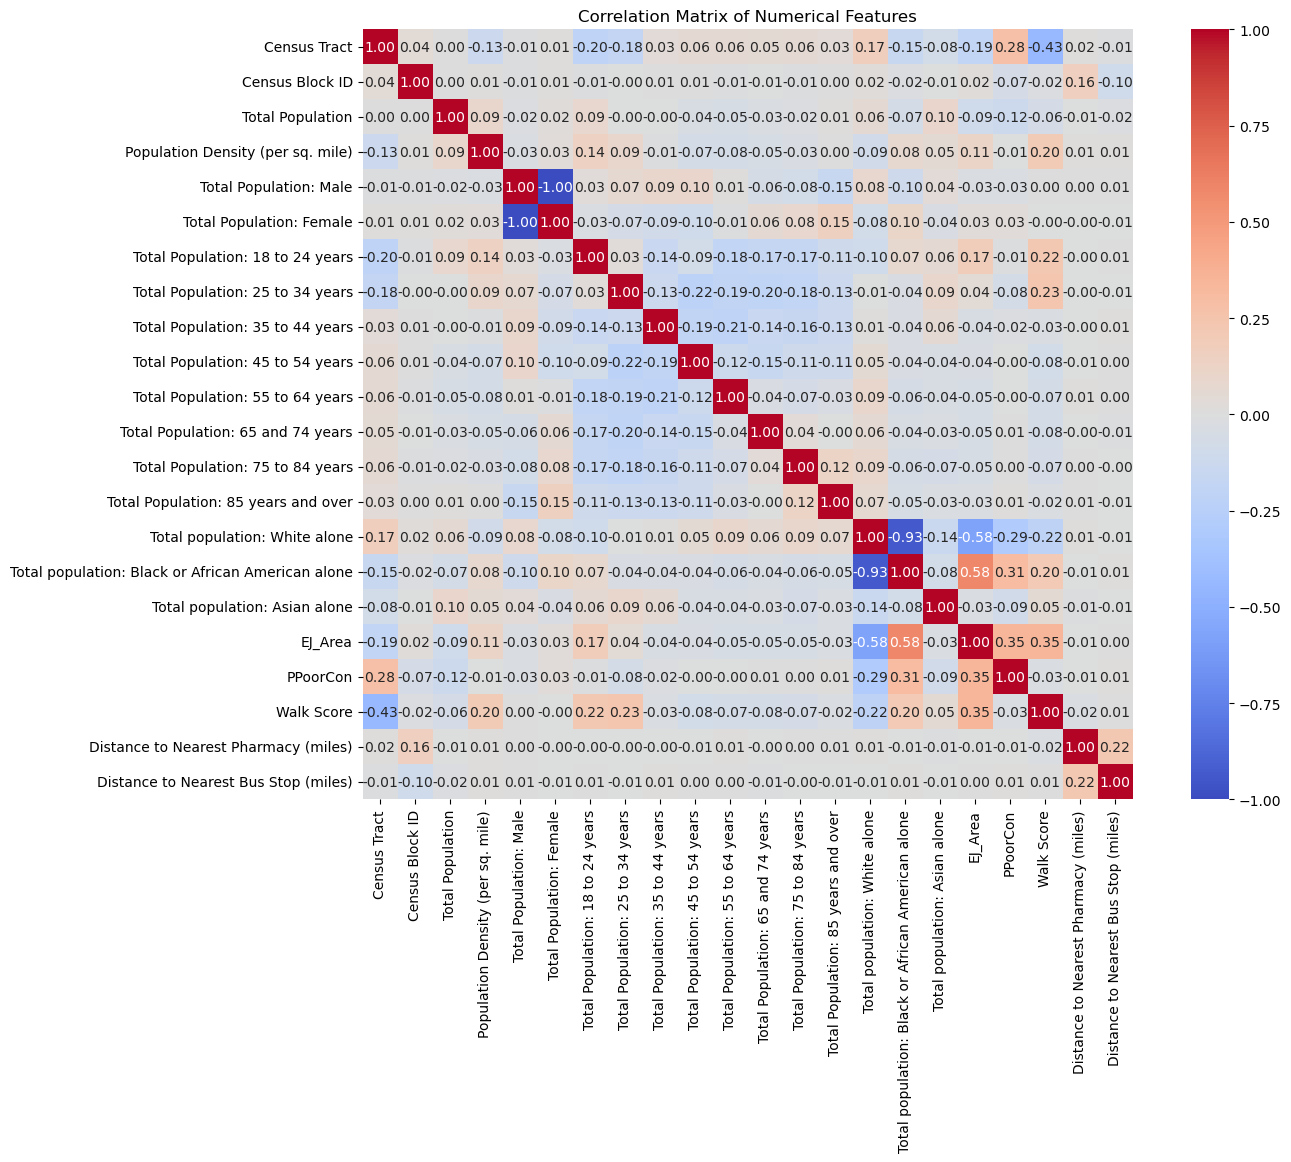

In [197]:
# Compute the correlation matrix for numerical columns
correlation_matrix = merged_data[numerical_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Residual Plot:

From our residual plot we learned:
- Linear relationship: No clear pattern and points are randomly distributed about zero
- Data is normally distributed
- Features are not correlated with each other

Clusters in our residual plot may correspond to specific population values that occur frequently in the data


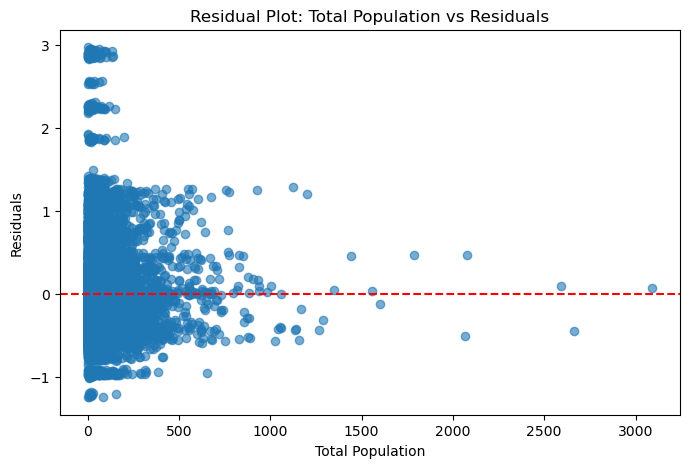

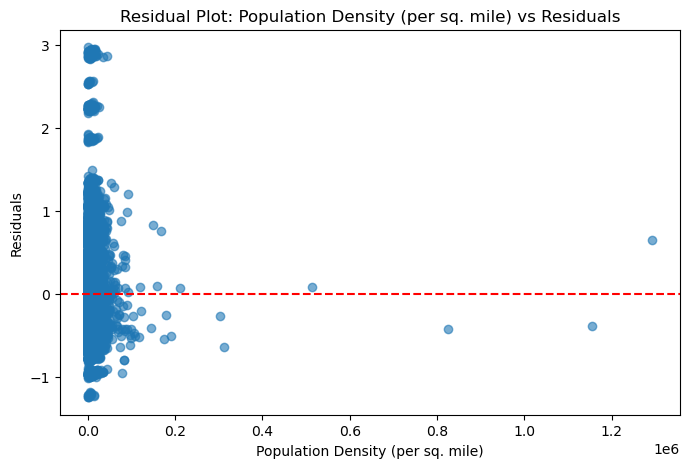

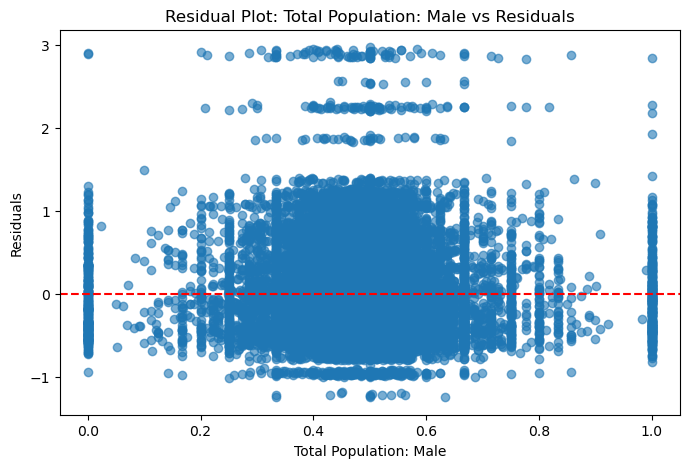

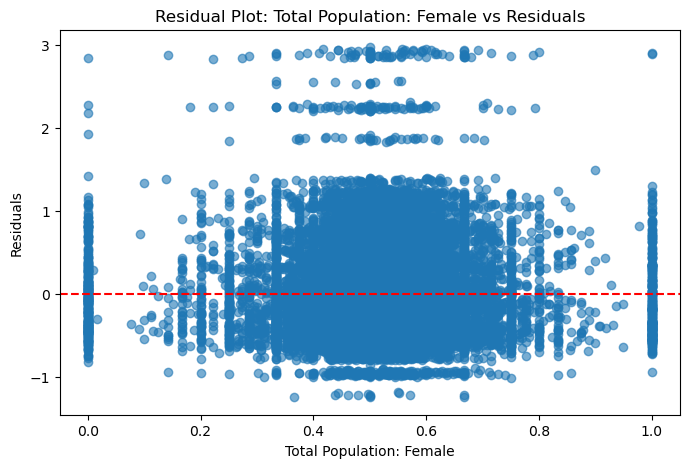

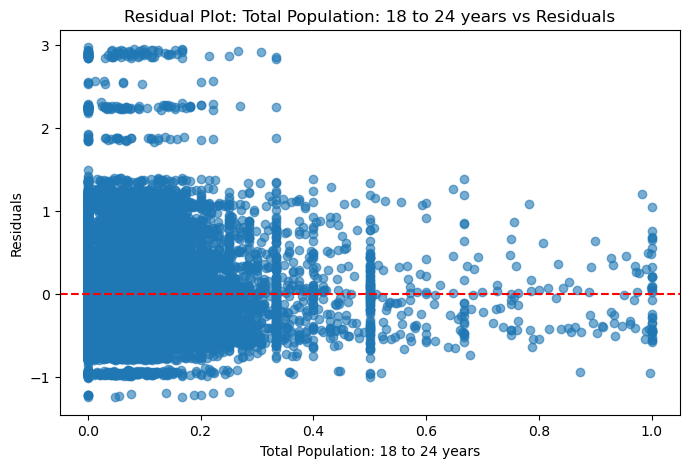

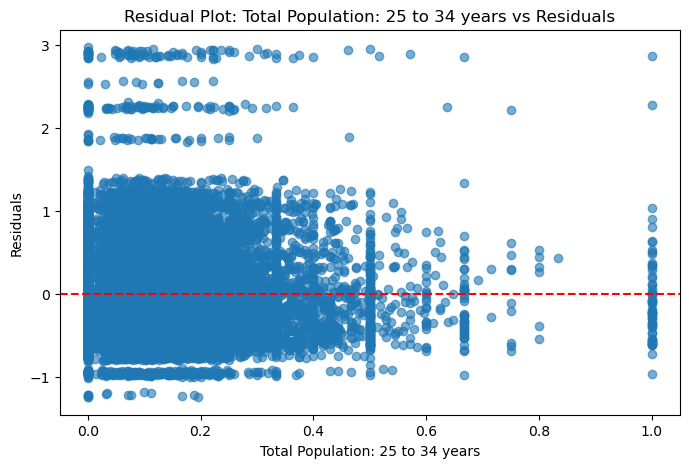

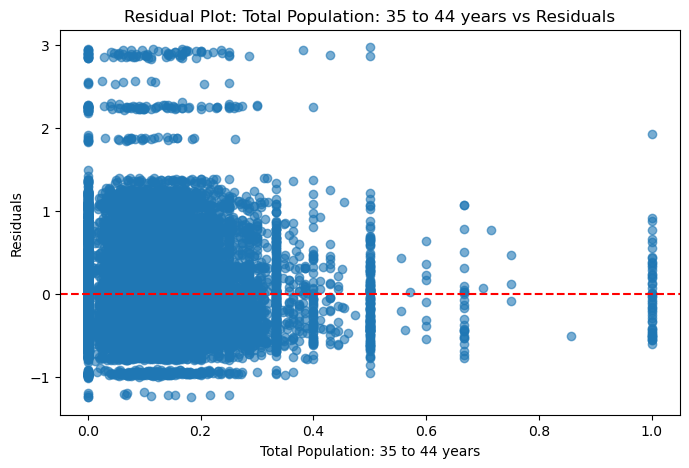

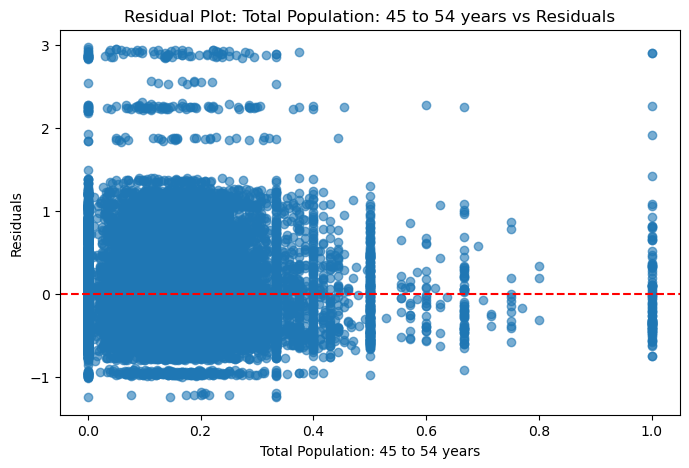

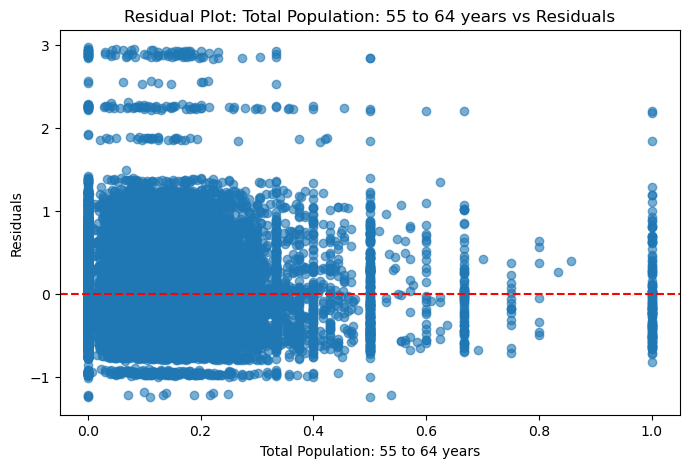

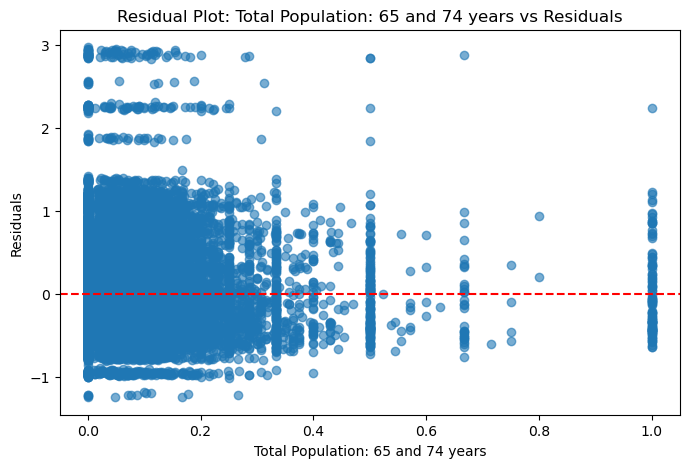

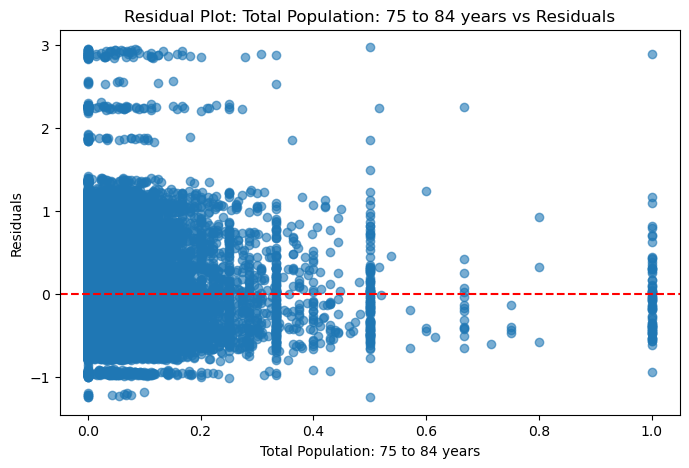

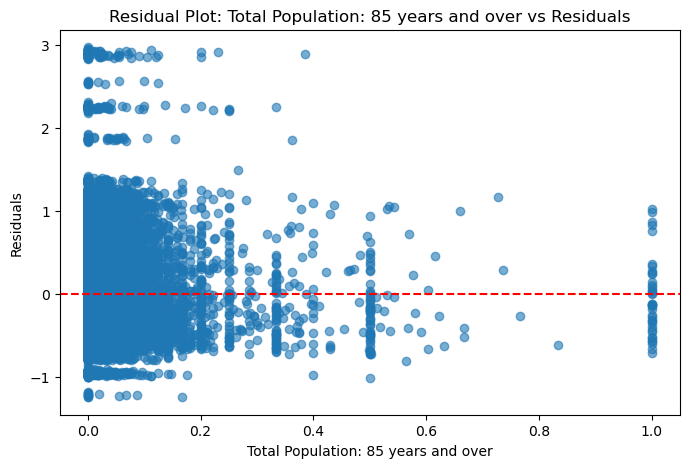

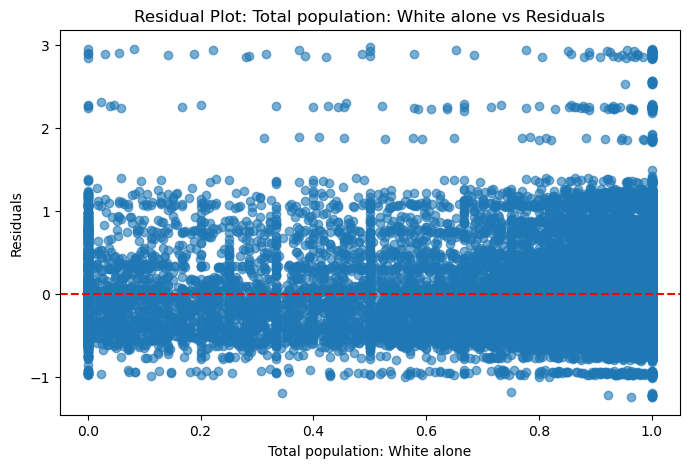

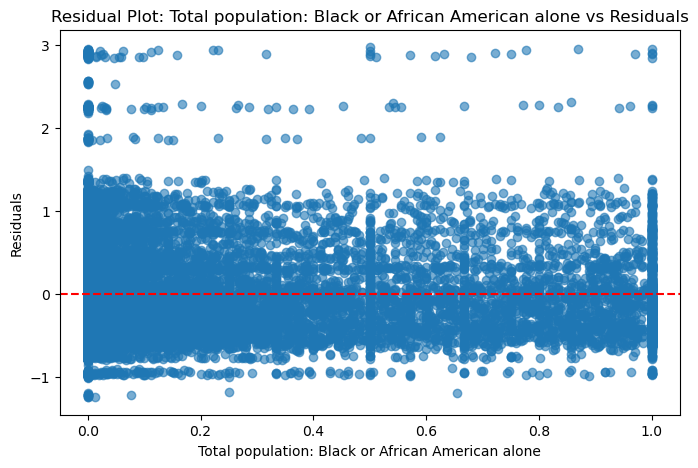

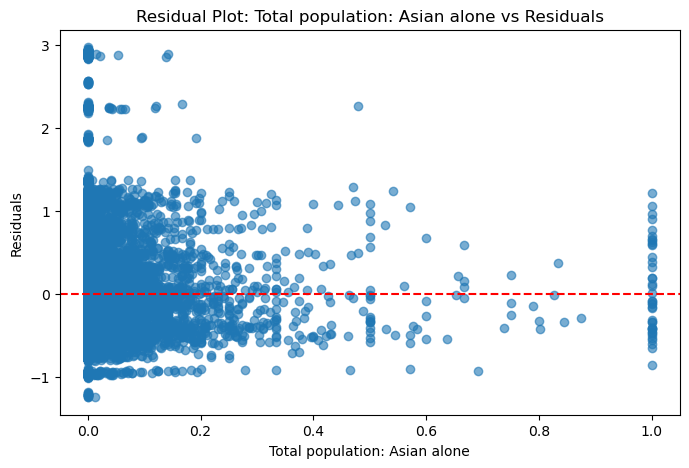

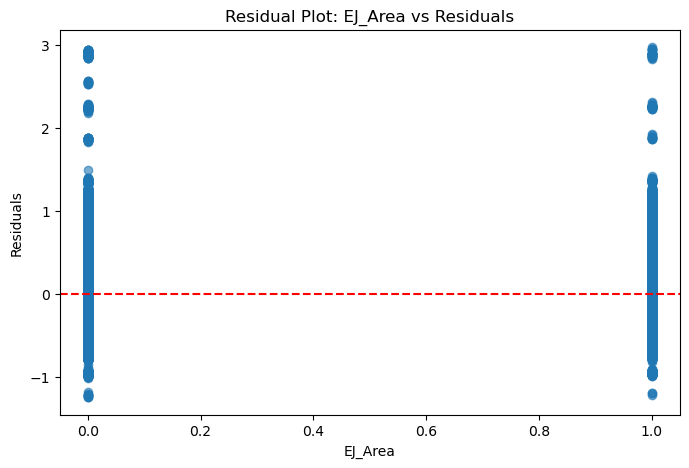

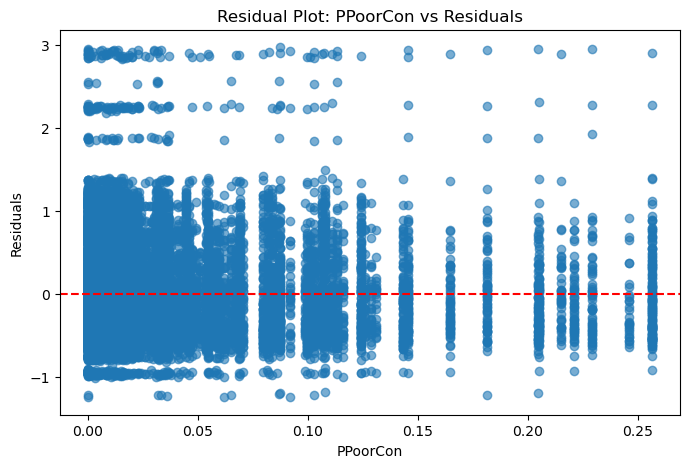

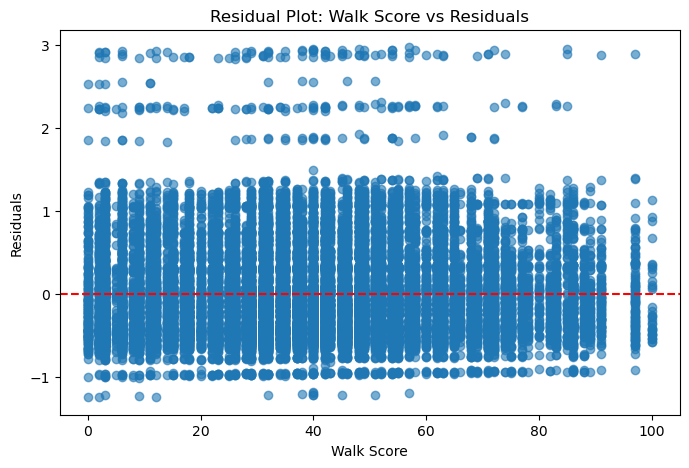

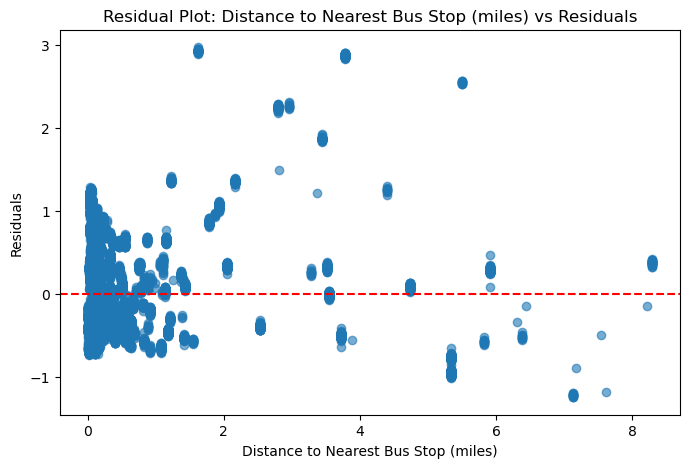

In [199]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define the target variable and feature set
target = 'Distance to Nearest Pharmacy (miles)'
features = merged_data.drop(columns=['Census Tract', 'Census Block ID','Distance to Nearest Pharmacy (miles)', 'Distance to Nearest Pharmacy (miles)', 'Is Pharmacy Desert (Yes/No)'])

# Select only numeric columns for regression
features_numeric = features.select_dtypes(include=['float64', 'int64'])

# Add a constant for the regression model
features_with_constant = sm.add_constant(features_numeric)

# Fit a linear regression model
model = sm.OLS(merged_data[target], features_with_constant).fit()

# Calculate residuals
residuals = model.resid

# Create residual plots for each feature
for feature in features_numeric.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(merged_data[feature], residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot: {feature} vs Residuals')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.show()

## Scatter Plot

From our scatter plot we learned:
- Predictors vs target is non linear
- There is no strong relationship among predictors and target varaible (distnace from nearest pharmacy)

It is improtantt to not that although there is no strong relationship among the predictors and target, this is neither a good or bad thing. It just means there are other predictors that may influence the probability of a pharmacy desert more than demographics chosen.

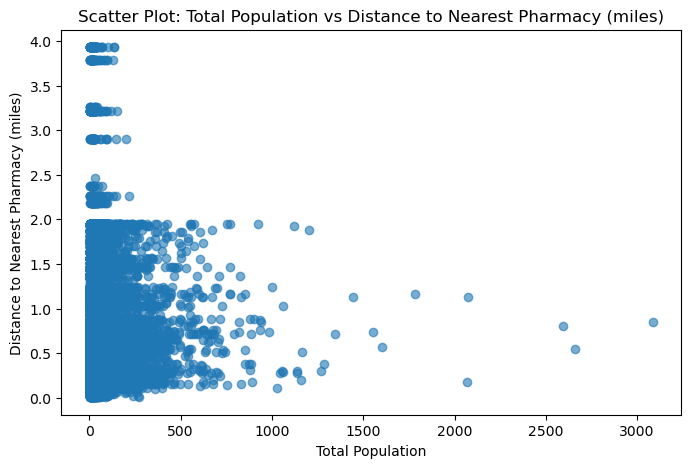

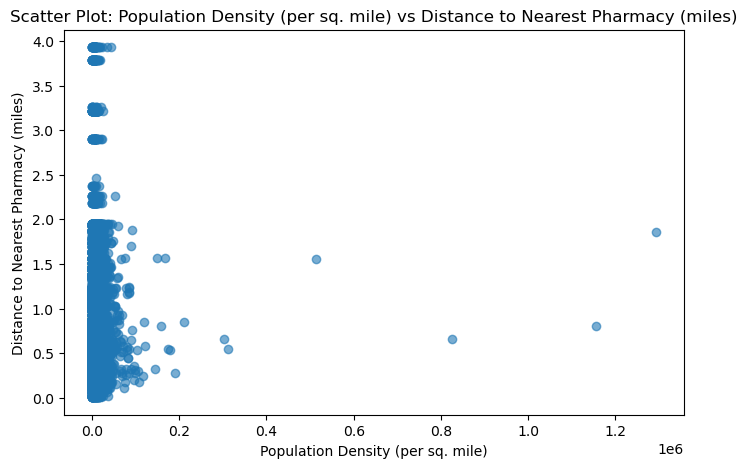

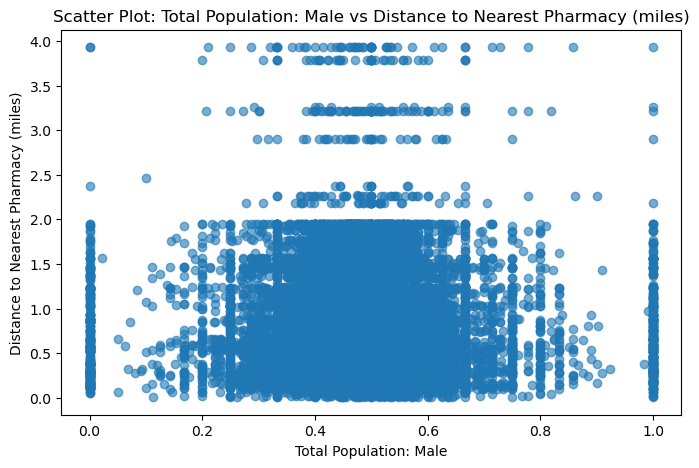

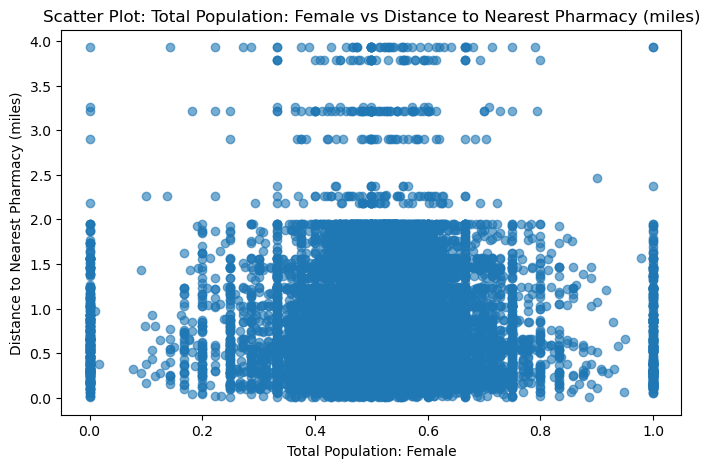

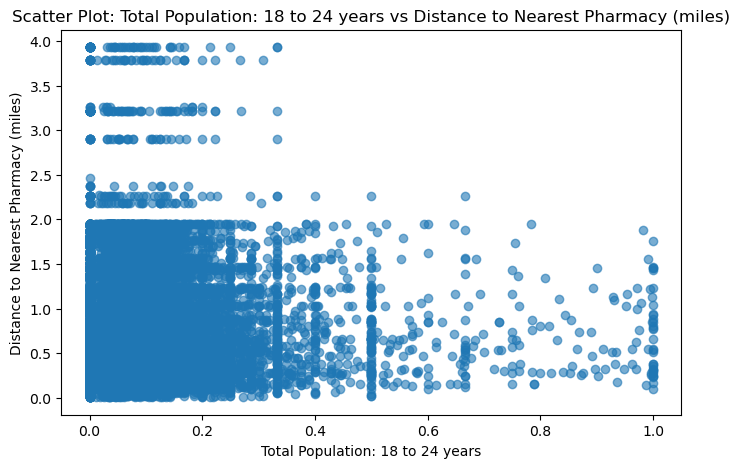

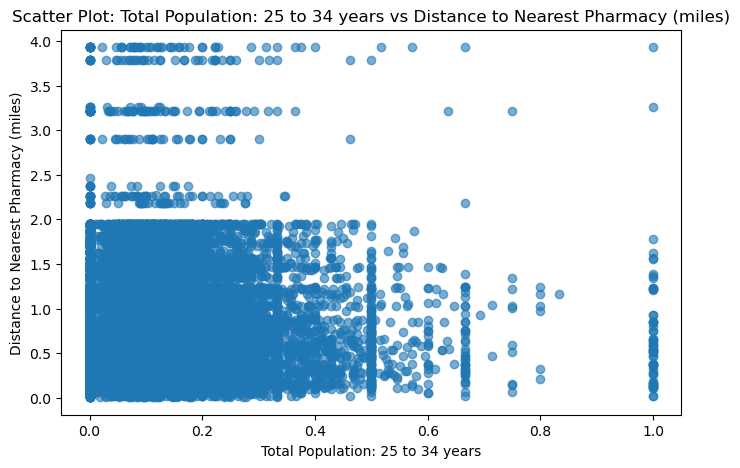

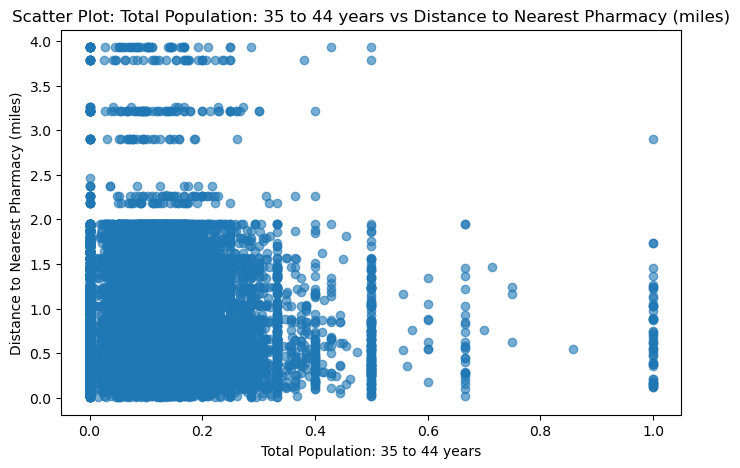

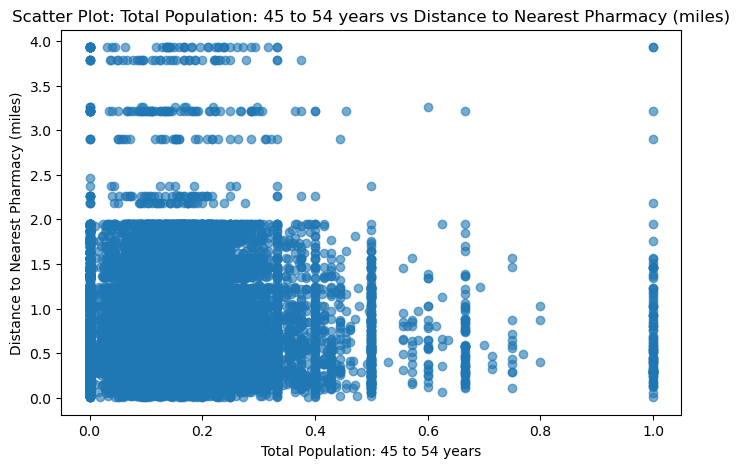

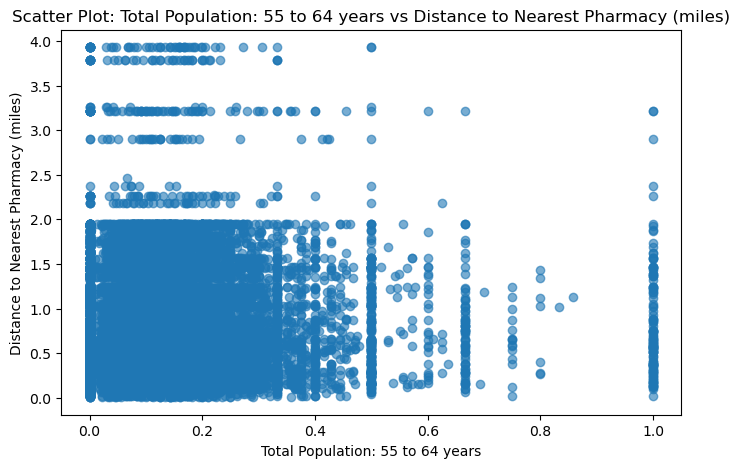

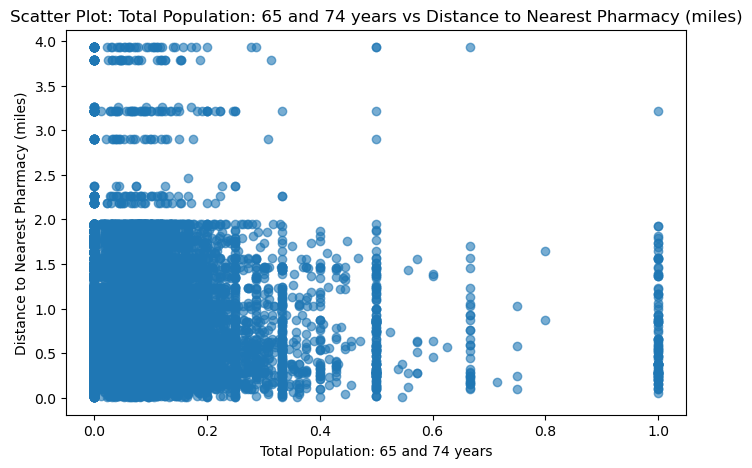

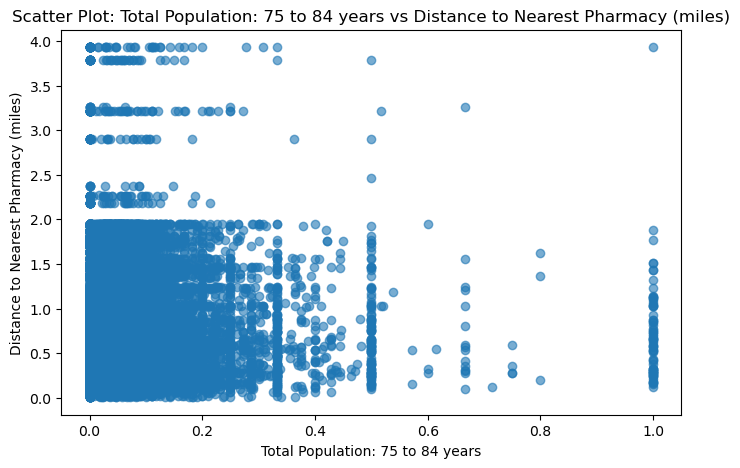

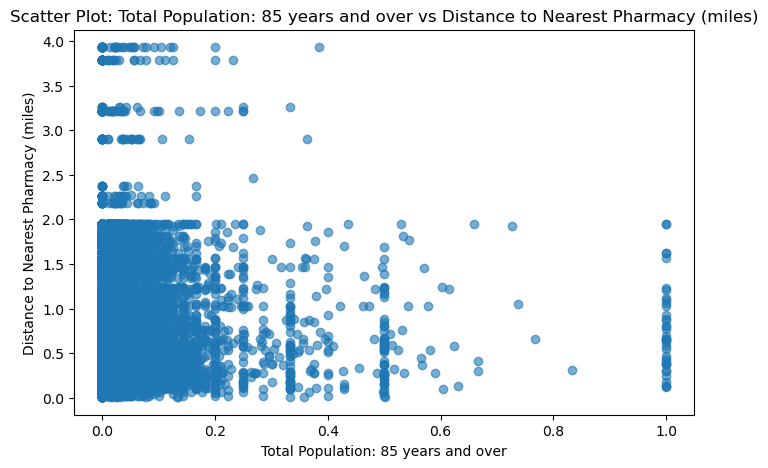

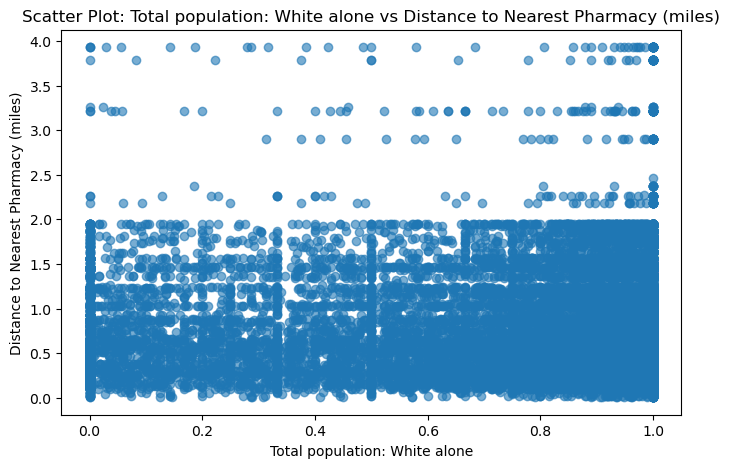

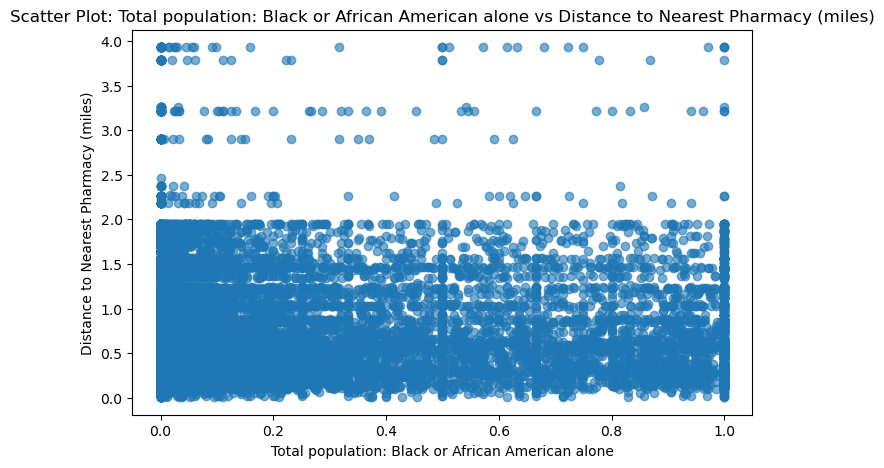

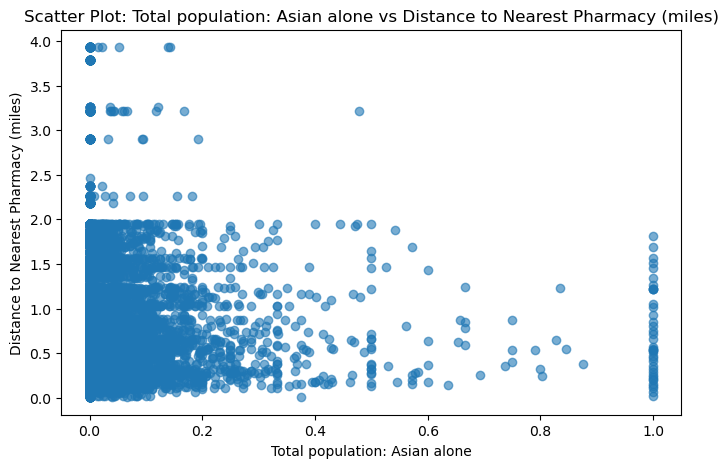

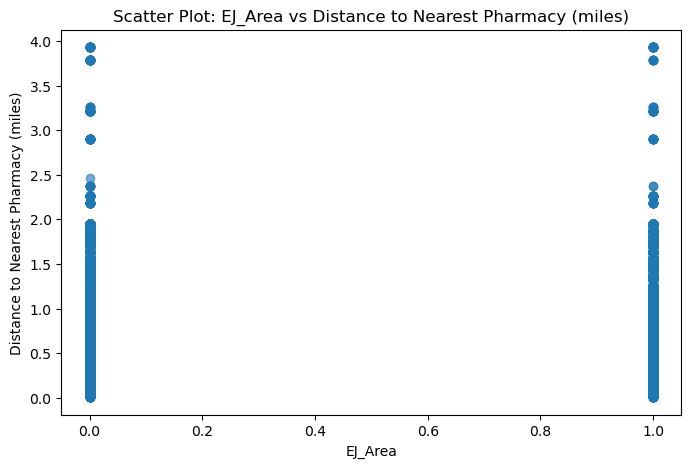

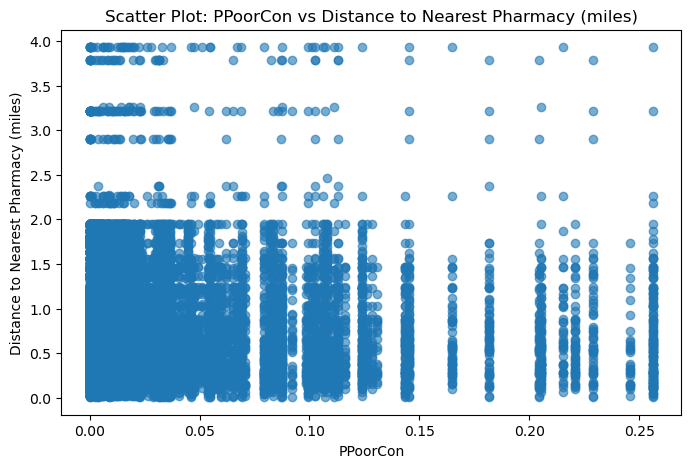

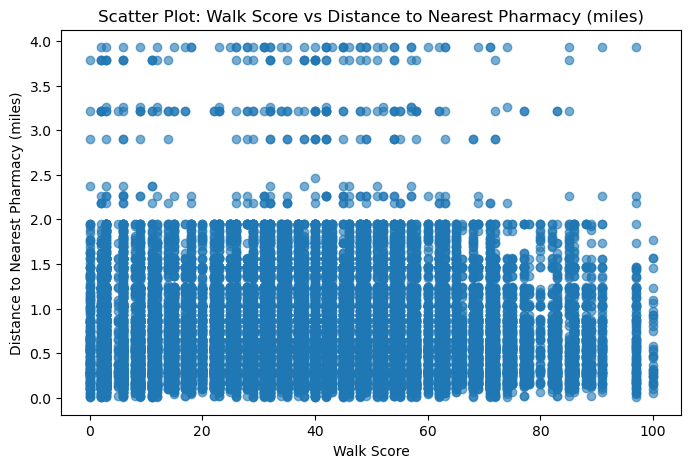

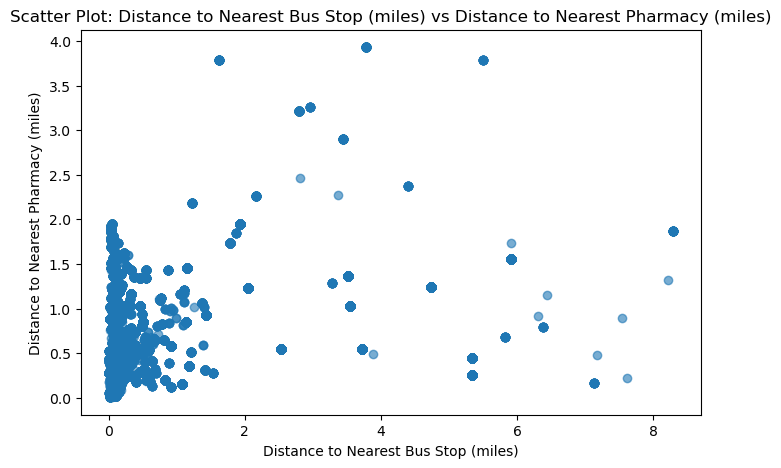

In [201]:
# Create scatter plots for each feature against the target variable
for feature in features_numeric.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(merged_data[feature], merged_data[target], alpha=0.6)
    plt.title(f'Scatter Plot: {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

## **Machine Learning Models**
*Testing for the best one*

We were able to choose which machine learning model based on certain pros and cons and with the relationships revealed in our data above
### **Naive Bayes** 
#### Pros: 
- Our dataset has mulitple features that we believe this machine learning model will be able to handle because Naive Bayes is typically efficient with high-dimensional data
- Naive Bayes is a robust model so if some of the features we selected are less relevant, it can handle them without significant loss of accuracy
- Our target variable is binary ("Is pharmacy desert (yes/no)") and Naive Bayes is well suited for such classification tasks
#### Cons:
- Naive bayes assumes feature independence which may introduce bias
- Sensitive to inbalanced data. Our dataset has a lot of outliers that may influence the accuracy of the model

### **Decision Tree**
#### Pros:
- Our data has a mix of categorical and numerical data which Decision Trees can handle well without extra data pre-processing
- Can handle and capture complex, non-linear relationships between features and target variable
- Makes no assumptions about the ditribution of features
- Can be used for both classificatition and regression tasks

#### Cons:
- Decision Trees are prone to offiting
- Bias towards dominant features
- Greedy algorithm which may not find the global best solution

### **K Nearest Neighbor**
#### Pros:
- Handles both numerical and categorical data well
- Can handle non-linear relationships well
  
#### Cons:
- Sensitive to irrelavent features or noise. Our outliers may have a negative impact on accruacy
- Biased towards imbalanced data
- KNN is less effective with high-dimensional datasets. Our dataset contains over 20 features

## Naive Bayes

In [204]:
merged_data['Is Pharmacy Desert (Yes/No)'] = merged_data['Is Pharmacy Desert (Yes/No)'].replace({'Yes' : 1, 'No': 0})

C:\Users\Maggie\AppData\Local\Temp\ipykernel_26504\3766306932.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['Is Pharmacy Desert (Yes/No)'] = merged_data['Is Pharmacy Desert (Yes/No)'].replace({'Yes' : 1, 'No': 0})


In [205]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]


In [206]:
#Test train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [207]:
#Model
nb = GaussianNB()
nb.fit(X_train, Y_train)
Y_pred = nb.predict(X_test)
Y_pred

C:\Users\Maggie\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [208]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      15045                            0  0.0
1      15200                            0  0.0
2      12689                            0  0.0
3       7994                            0  0.0
4       2072                            0  0.0
...      ...                          ...  ...
17526   9372                            1  NaN
17527   7291                            0  NaN
17528  17728                            0  NaN
17529   7293                            0  NaN
17530  17673                            0  NaN

[17531 rows x 3 columns]

In [209]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_test = le.fit_transform(Y_test)  # Converts labels to numeric

C:\Users\Maggie\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [210]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.9078256901665526
0.5


Accuracy around 91% and AUC around 50%

## Decision Tree

In [213]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

In [214]:
#Test train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [215]:
#model
dt= DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [216]:
Y_pred = dt.predict(X_test)
Y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [217]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      15045                            0  0.0
1      15200                            0  0.0
2      12689                            0  0.0
3       7994                            0  0.0
4       2072                            0  0.0
...      ...                          ...  ...
17526   9372                            1  NaN
17527   7291                            0  NaN
17528  17728                            0  NaN
17529   7293                            0  NaN
17530  17673                            0  NaN

[17531 rows x 3 columns]

In [218]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.9078256901665526
0.5


Accuracy is 91% and AUC is 50%

## K Nearest Neighbor

In [221]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

In [222]:
#Test train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

In [223]:
#model
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, Y_train)

C:\Users\Maggie\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [224]:
Y_pred = knn.predict(X_test)
Y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [225]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      15045                            0  0.0
1      15200                            0  0.0
2      12689                            0  0.0
3       7994                            0  0.0
4       2072                            0  0.0
...      ...                          ...  ...
17526   9372                            1  NaN
17527   7291                            0  NaN
17528  17728                            0  NaN
17529   7293                            0  NaN
17530  17673                            0  NaN

[17531 rows x 3 columns]

In [226]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.8991558293406343
0.49744885898491836


Accuracy is 90% and AUC is 50%

## **Results**

Our best model was Decision Tree but Naive Bayes was a close second. Both models are able to predict where the next pharmacy desert may appear in Allegheny County with 90% accuracy. However, the AUC score of 50% suggests our model is no better than random guessing

**Reasons why Decision Tree performed the best**
- There were a lot of non linear relationships in our data that the decision tree was able to model better than Naive Bayes and KNN
- Decision trees automatically peform feature selection during the training so if our dataset had any highly relevant predictors the tree would focus on these (although this may lead to overfitting which could explain the high accuracy score)
- Unlike KNN the decision tree was able to handle the high dimensional dataset

KNN underperformed because of the cons listed above

## **Attempting to Improve AUC**

AUC is the percentage of area under the ROC curve. Typically, the goal is to have as close to 100 percent as possible because that means our model is predicting accurately with true positives. In the 3 models above, we had an AUC of around 50% for each of them. This implies that our model does no better at predicting than random guessing. 


## Random Forest
We decided to try using a random forest model to see if it would return a better AUC. We chose random forest because it is essentially a more advanced version of a tree model which was our most accurate of the initial tests. It better analyzes the complex relationships that our predictors may have with the target.

In [231]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

In [232]:
#Test Train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [233]:
#Model
rf = RandomForestClassifier(random_state=1, max_depth=10)

rf.fit(X_train, Y_train)

C:\Users\Maggie\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=10, random_state=1)

In [234]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [235]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      17214                            0  0.0
1      13510                            0  0.0
2       2655                            0  0.0
3       4344                            0  0.0
4       8423                            1  0.0
...      ...                          ...  ...
17526  10955                            0  NaN
17527  17289                            0  NaN
17528   5192                            1  NaN
17529  12172                            0  NaN
17530    235                            0  NaN

[17531 rows x 3 columns]

In [236]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.8977869039470682
0.5026373109203135


## XG Boost
After random forest didn't return a better AUC, we decided to try an XGBoost model. XGBoost is also an example of a more advanced tree model. It could be especially helpful because it handles nonlinearities well, which we believe is one of the leading causes of our AUC.

In [238]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

In [239]:
#Test Train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [240]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1)
xgb.fit(X_train, Y_train)

C:\Users\Maggie\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [241]:
y_pred = xgb.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [242]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      17214                            0  0.0
1      13510                            0  0.0
2       2655                            0  0.0
3       4344                            0  0.0
4       8423                            1  0.0
...      ...                          ...  ...
17526  10955                            0  NaN
17527  17289                            0  NaN
17528   5192                            1  NaN
17529  12172                            0  NaN
17530    235                            0  NaN

[17531 rows x 3 columns]

In [243]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.8977869039470682
0.5026373109203135


## Baseline Majority Classifier
After neither of the previous models returned a better ROC, we decided that we need to test if our models are just predicting with the majority classifications.

In [245]:
# Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

In [246]:
#Test Train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [247]:
# Create a majority classifier (DummyClassifier)
majority_clf = DummyClassifier(strategy="most_frequent", random_state=42)
majority_clf.fit(X_train, Y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [248]:
Y_pred = majority_clf.predict(X_test)
Y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [249]:
comp = pd.concat([Y_train.reset_index(), pd.Series(Y_pred)], axis=1)
comp

index  Is Pharmacy Desert (Yes/No)    0
0      17214                            0  0.0
1      13510                            0  0.0
2       2655                            0  0.0
3       4344                            0  0.0
4       8423                            1  0.0
...      ...                          ...  ...
17526  10955                            0  NaN
17527  17289                            0  NaN
17528   5192                            1  NaN
17529  12172                            0  NaN
17530    235                            0  NaN

[17531 rows x 3 columns]

In [250]:
# Accuracy and AUC
print(metrics.accuracy_score(Y_test, Y_pred))
print(metrics.roc_auc_score(Y_test, Y_pred))

0.9046315309148985
0.5


Since we still returned a 50% AUC, we need to attempt a diferent method

## **Re- Train models**

In [253]:

# Assuming 'df' is your DataFrame and 'binary_column' is the binary column you want to balance
df_class_0 = merged_data[merged_data['Is Pharmacy Desert (Yes/No)'] == 0]
df_class_1 = merged_data[merged_data['Is Pharmacy Desert (Yes/No)'] == 1]

# Undersample the class with more instances (class 0 in this case) to match the class 1
df_class_0_undersampled = df_class_0.sample(n=len(df_class_1), random_state=42)

# Combine the undersampled class 0 with class 1
df_balanced = pd.concat([df_class_0_undersampled, df_class_1])

# Shuffle the rows to ensure randomness
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(df_balanced['Is Pharmacy Desert (Yes/No)'].value_counts())

Is Pharmacy Desert (Yes/No)
0    2065
1    2065
Name: count, dtype: int64


#### Now that we evened out the pharmacy deserts and non pharmacy deserts, it could more accurately train our model.

## Naive Bayes

In [256]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)


In [257]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.7263849593866935
0.7836605353469542


## Decision Tree

In [259]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the Decison Tree model
model = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [260]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.9995436707127864
0.9975786924939467


## KNN

In [262]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data.drop(columns=['Is Pharmacy Desert (Yes/No)'])
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the KNN model
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [263]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.754814273980104
0.6819891756612302


## **Results**

After creating a balanced dataframe with equal yes and no deserts our model accuracy and AUC score improved. This is because the no's longer outweigh the yes's therfore reducing the amount of noise in our dataset

## **Testing Different Predictors to Find the Best Ones**

## Testing only ages of population

In [267]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced[['Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over']]
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data[['Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over']]
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the Decison Tree model
model = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [268]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.5296157707401661
0.5132027924632427


## Testing only gender and race

In [270]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced[['Total Population: Male', 'Total Population: Female', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone']]
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data[['Total Population: Male', 'Total Population: Female', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone']]
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the Decison Tree model
model = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [271]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.10810440814091449
0.5041867674794578


## Testing pop density, EJA, poor conditions and walkscore

In [273]:
# Define features (X) and target (y) for training and testing datasets
X_train = df_balanced[['Total Population', 'Population Density (per sq. mile)', 'EJ_Area','PPoorCon', 'Walk Score']]
y_train = df_balanced['Is Pharmacy Desert (Yes/No)']

X_test = merged_data[['Total Population', 'Population Density (per sq. mile)', 'EJ_Area','PPoorCon', 'Walk Score']]
y_test = merged_data['Is Pharmacy Desert (Yes/No)']

# Train the Decison Tree model
model = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)

In [274]:
# Accuracy and AUC
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred))

0.14018435703203433
0.51213314275809


Selecting different predictors to see if any make the model more or less accurate didnt really affect anything in the accuracy and auc implying that all of the predictors are decent

## Using the SHAP function to find the best predictors
SHAP is a a function that returns a bar chart of the predictors that have the highest average impact on the model. We did this using the XGBoost model because it is a more advanced tree model and has a better analysis of what predictors are most relevant

In [277]:
#Define X and Y
X = merged_data[['Total Population', 'Population Density (per sq. mile)', 'Total Population: Male', 'Total Population: Female', 'Total Population: 18 to 24 years', 'Total Population: 25 to 34 years', 'Total Population: 35 to 44 years', 'Total Population: 45 to 54 years', 'Total Population: 55 to 64 years' , 'Total Population: 65 and 74 years', 'Total Population: 75 to 84 years', 'Total Population: 85 years and over', 'Total population: White alone', 'Total population: Black or African American alone', 'Total population: Asian alone', 'EJ_Area','PPoorCon', 'Walk Score']]

Y = merged_data[['Is Pharmacy Desert (Yes/No)']]

#Test Train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=1)
xgb.fit(X_train, Y_train)

y_pred = xgb.predict(X_test)
y_pred

C:\Users\Maggie\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([0, 0, 0, ..., 0, 0, 0])

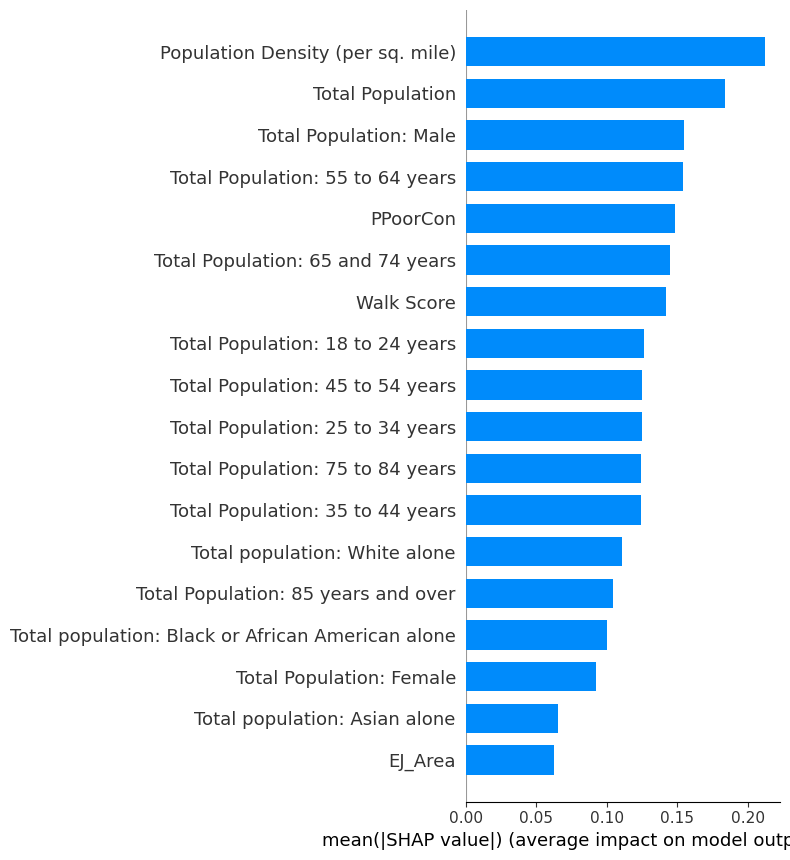

In [278]:
# Create SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")  

## **Conclusion**
- Using our definition of a pharmacy desert, we can still assume there are deserts present in Allegheny County
- All of our research shows that our predictors could affect pharmacy deserts even if our model doesn’t show it
- A classification model is the best option for determining which census blocks are pharmacy deserts

